# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: user 1.02 s, sys: 110 ms, total: 1.13 s
Wall time: 1.13 s


,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,...,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60,record,fraud_label
0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
2,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0
3,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0
4,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 20

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'fulladdress_day_since',
 'name_dob_count_30',
 'address_unique_count_for_name_homephone_60',
 'fulladdress_unique_count_for_dob_homephone_3',
 'address_unique_count_for_homephone_name_dob_30',
 'address_unique_count_for_ssn_name_dob_14',
 'address_day_since',
 'address_count_14',
 'address_count_7',
 'address_count_0_by_30',
 'address_unique_count_for_homephone_name_dob_60',
 'fulladdress_count_0_by_30',
 'address_unique_count_for_ssn_zip5_60',
 'address_unique_count_for_ssn_name_60',
 'address_unique_count_for_ssn_firstname_60',
 'address_unique_count_for_ssn_name_dob_60',
 'address_unique_count_for_dob_homephone_60',
 'address_unique_count_for_ssn_homephone_60',
 'address_unique_count_for_ssn_lastname_60',
 'address_unique_count_for_ssn_60']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,...,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
vars.shape

(1000000, 22)

In [6]:
vars['Fraud'].sum()

14393.0

In [7]:
vars.head(10)

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,...,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,6.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,7.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,8.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,9.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,10.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
vars.shape

(1000000, 22)

In [9]:
vars.describe()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,...,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,...,1.069813,29.489603,1.063754,1.063893,1.063768,1.069072,1.069604,1.066676,1.063742,1.063595
std,288675.278933,0.119104,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,...,0.703726,2.834776,0.699405,0.699542,0.699434,0.703730,0.703504,0.701785,0.699411,0.699296
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.304348,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,250000.750000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,...,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,500000.500000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,...,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,750000.250000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,...,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1000000.000000,1.000000,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [10]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,1.042577,29.358254,1.069813,29.489603,1.063754,1.063893,1.063768,1.069072,1.069604,1.066676,1.063742,1.063595
std,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,0.585789,3.205310,0.703726,2.834776,0.699405,0.699542,0.699434,0.703730,0.703504,0.701785,0.699411,0.699296
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.304348,1.000000,1.304348,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# use this to cap variables. For some problems it helps
Clip = 10

In [14]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,-4.623209e-14,3.451346e-14,-8.867842e-14,1.657446e-14,-7.463379e-14,-3.191538e-14,-5.907877e-13,5.280565e-14,2.188792e-14,-6.455372e-14,-3.886573e-14,-1.440218e-13,8.258327e-14,4.694062e-14,-6.385813e-14,6.460940e-14,-2.021172e-14,-8.062292e-14,-8.483792e-14,3.694335e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.280209e+00,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,-3.053486e+00,-8.860966e-02,-7.268319e-02,-8.752323e+00,-9.920487e-02,-9.942674e+00,-9.115457e-02,-9.133546e-02,-9.117084e-02,-9.815132e-02,-9.893904e-02,-9.500910e-02,-9.113671e-02,-9.094144e-02
25%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02,-9.815132e-02,-9.893904e-02,-9.500910e-02,-9.113671e-02,-9.094144e-02
50%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02,-9.815132e-02,-9.893904e-02,-9.500910e-02,-9.113671e-02,-9.094144e-02
75%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02,-9.815132e-02,-9.893904e-02,-9.500910e-02,-9.113671e-02,-9.094144e-02
max,4.030326e-01,6.630026e+01,4.127016e+01,5.368356e+01,4.512894e+01,4.767899e+01,4.281212e-01,4.683076e+01,4.943321e+01,2.002135e-01,4.111004e+01,1.800485e-01,4.137264e+01,4.136435e+01,4.137092e+01,4.111085e+01,4.112329e+01,4.122816e+01,4.137234e+01,4.137933e+01


In [15]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [17]:
alphas = 10**np.linspace(2,9,30)*0.5

In [18]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [19]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 20)

CPU times: user 1.22 s, sys: 313 ms, total: 1.53 s
Wall time: 274 ms


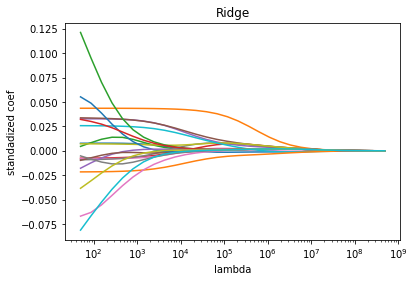

In [20]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [21]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [22]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

/Users/santhoshinijayachandran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.673e+02, tolerance: 8.290e-01
  model = cd_fast.enet_coordinate_descent(
/Users/santhoshinijayachandran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.722e+02, tolerance: 8.290e-01
  model = cd_fast.enet_coordinate_descent(
/Users/santhoshinijayachandran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Selected Features: []
CPU times: user 44min 9s, sys: 2min 24s, total: 46min 34s
Wall time: 6min 2s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


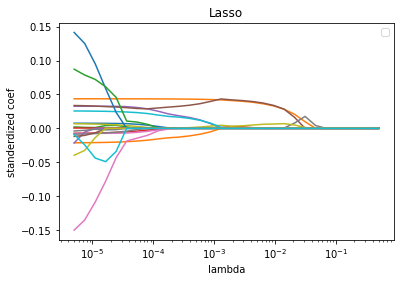

In [23]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [24]:
len(X_trntst.columns)

20

In [25]:
X_trntst_save = X_trntst.copy()

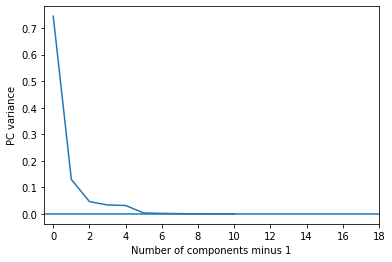

In [26]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [27]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453
1,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453
2,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453
3,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453
4,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453


In [28]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
833507,-0.070785,-1.844123,-1.523856,1.419762,0.550140,0.007946
833508,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453
833509,1.721135,-7.939800,1.146716,-1.162357,-1.443887,0.027049
833510,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453
833511,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453


In [29]:
X_trntst.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.031522,-0.001708,-0.000377,0.001320,0.000348,0.000852,0.031615,0.000682,0.001052,0.000987,-0.000473,0.000686,-0.000253,-0.000254,-0.000254,-0.000428,-0.000477,-0.000390,-0.000261,-0.000257
std,0.981263,0.979550,0.996756,1.013675,1.002736,1.008244,0.983233,1.007653,1.011013,0.997512,0.996709,0.998151,0.997370,0.997336,0.997358,0.996830,0.996707,0.996882,0.997339,0.997364
min,-3.280209,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,-3.053486,-0.088610,-0.072683,-8.752323,-0.099205,-9.942674,-0.091155,-0.091335,-0.091171,-0.098151,-0.098939,-0.095009,-0.091137,-0.090941
25%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171,-0.098151,-0.098939,-0.095009,-0.091137,-0.090941
50%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171,-0.098151,-0.098939,-0.095009,-0.091137,-0.090941
75%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171,-0.098151,-0.098939,-0.095009,-0.091137,-0.090941
max,0.403033,66.300262,41.270156,53.683556,45.128940,47.678988,0.428121,46.830762,49.433212,0.200213,41.110043,0.180049,41.372637,41.364353,41.370917,41.110850,41.123290,41.228162,41.372336,41.379326


In [30]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.029895,-0.196186,-0.123807,0.115339,0.064737,-0.001130
std,3.803802,1.671683,1.102682,0.919456,0.888131,0.314408
min,-0.438274,-17.950633,-4.543559,-19.915926,-10.344204,-4.455905
25%,-0.438274,-0.192565,0.062205,-0.117043,-0.088013,0.013453
50%,-0.438274,0.511058,0.129668,-0.117043,-0.088013,0.013453
75%,-0.322386,0.511058,0.129668,-0.117043,-0.088013,0.013453
max,166.461000,27.275917,46.812417,22.004800,39.902416,15.400300


In [31]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [32]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,3.071921e-14,8.495153e-14,-1.060037e-12,1.121628e-12,1.244340e-13,7.342312e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.138666e-01,-1.354054e+01,-5.392581e+00,-2.482511e+01,-1.276474e+01,-1.822815e+01
25%,-1.138666e-01,3.173056e-01,1.341420e-01,-1.416840e-01,-1.098515e-01,4.571937e-02
50%,-1.138666e-01,3.173056e-01,1.341420e-01,-1.416840e-01,-1.098515e-01,4.571937e-02
75%,-1.138666e-01,3.173056e-01,1.341420e-01,-1.416840e-01,-1.098515e-01,4.571937e-02
max,4.318554e+01,1.749406e+01,5.705148e+01,3.141954e+01,5.367800e+01,5.291363e+01


In [33]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.007767,-0.121808,-0.128079,0.139622,0.080799,-0.003839
std,0.988254,1.037914,1.140729,1.113032,1.108496,1.068468
min,-0.113867,-11.145190,-4.700330,-24.108888,-12.910829,-15.142694
25%,-0.113867,-0.119560,0.064351,-0.141684,-0.109852,0.045719
50%,-0.113867,0.317306,0.134142,-0.141684,-0.109852,0.045719
75%,-0.083758,0.317306,0.134142,-0.141684,-0.109852,0.045719
max,43.247702,16.935072,48.427640,26.637540,49.803085,52.335505


In [34]:
X_trntst_pca.shape

(833507, 6)

In [35]:
X_oot_orig_pca.shape

(166493, 6)

## Subsample the larger class if desired

In [36]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 20) 23841


In [37]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [38]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [39]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=5, penalty='elasticnet',C=1 , solver = 'saga', l1_ratio=0.4)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

/Users/santhoshinijayachandran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0 0.48005255613951264 0.4751031636863824 0.46353730092204526


/Users/santhoshinijayachandran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1 0.4757200666507974 0.4871012482662968 0.46437552388935455


/Users/santhoshinijayachandran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


2 0.4822485207100592 0.46977790272701714 0.46353730092204526


/Users/santhoshinijayachandran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


3 0.47689375893282515 0.4821379119357519 0.46353730092204526
4 0.4819852063946552 0.4692413793103448 0.46269907795473597
trn    0.479380
tst    0.476672
oot    0.463537
dtype: float64
CPU times: user 13.9 s, sys: 2.16 s, total: 16.1 s
Wall time: 6.47 s


/Users/santhoshinijayachandran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [40]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion = "gini", max_depth= 25 ,min_samples_split=50,min_samples_leaf=30, splitter ='best', max_features=30)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.5402708481824662 0.523265533574812 0.5016764459346186
1 0.5385076775431862 0.5284663579406156 0.5058675607711651
2 0.5461346633416458 0.5119910764082544 0.5029337803855826
3 0.5410999408633944 0.5171734234234234 0.5037720033528919
4 0.5406368821292775 0.5249234196602618 0.5020955574182733
trn    0.541330
tst    0.521164
oot    0.503269
dtype: float64
CPU times: user 3.62 s, sys: 265 ms, total: 3.88 s
Wall time: 2.87 s


In [41]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(bootstrap = 'TRUE', n_estimators=80,max_depth=15, max_features= 10 ,min_samples_split=8,min_samples_leaf=5,criterion='entropy')
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5337232899606065 0.5358126721763086 0.5046102263202011
1 0.540862520848225 0.519512870190977 0.5046102263202011
2 0.5414925373134328 0.5198237885462555 0.5037720033528919
3 0.5398451459201906 0.5235326688815061 0.5058675607711651
4 0.5381779257849667 0.5259794387329814 0.5037720033528919
trn    0.538820
tst    0.524932
oot    0.504526
dtype: float64
CPU times: user 1min 21s, sys: 211 ms, total: 1min 22s
Wall time: 1min 22s


In [42]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(max_depth=10,n_estimators=1000,learning_rate= 0.01)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5316485592820028 0.5213337100875953 0.5092204526404024
1 0.5298419438546828 0.5318787191839048 0.508382229673093
2 0.5347163928528601 0.5166303162486369 0.5071248952221291
3 0.5338095238095238 0.5176046576102024 0.508382229673093
4 0.529284685549688 0.5314285714285715 0.5058675607711651
trn    0.531860
tst    0.523775
oot    0.507795
dtype: float64
CPU times: user 12min 26s, sys: 36.6 s, total: 13min 2s
Wall time: 1min 45s


In [43]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(max_depth=10,n_estimators=1000,learning_rate= 0.01)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5369705671213209 0.5220608385859139 0.5062866722548198
1 0.5358880056946257 0.5234768026830632 0.5062866722548198
2 0.5375400308385719 0.5209731543624161 0.5054484492875104
3 0.5399689329669016 0.5164925783397472 0.5037720033528919
4 0.538 0.5220986598232107 0.5054484492875104
trn    0.537674
tst    0.521020
oot    0.505448
dtype: float64
CPU times: user 2h 21min 38s, sys: 8min 8s, total: 2h 29min 47s
Wall time: 19min 46s


In [44]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = CatBoostClassifier(max_depth=10,n_estimators=1000,learning_rate= 0.01)


    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0:	learn: 0.6694331	total: 121ms	remaining: 2m
1:	learn: 0.6466866	total: 146ms	remaining: 1m 12s
2:	learn: 0.6244272	total: 196ms	remaining: 1m 5s
3:	learn: 0.6030991	total: 242ms	remaining: 1m
4:	learn: 0.5826913	total: 290ms	remaining: 57.7s
5:	learn: 0.5628604	total: 337ms	remaining: 55.9s
6:	learn: 0.5438308	total: 383ms	remaining: 54.3s
7:	learn: 0.5253474	total: 431ms	remaining: 53.4s
8:	learn: 0.5076735	total: 478ms	remaining: 52.7s
9:	learn: 0.4905278	total: 525ms	remaining: 52s
10:	learn: 0.4740627	total: 574ms	remaining: 51.6s
11:	learn: 0.4582619	total: 621ms	remaining: 51.1s
12:	learn: 0.4430465	total: 668ms	remaining: 50.7s
13:	learn: 0.4283181	total: 715ms	remaining: 50.4s
14:	learn: 0.4144598	total: 762ms	remaining: 50s
15:	learn: 0.4009152	total: 809ms	remaining: 49.7s
16:	learn: 0.3879410	total: 856ms	remaining: 49.5s
17:	learn: 0.3753859	total: 905ms	remaining: 49.4s
18:	learn: 0.3634971	total: 955ms	remaining: 49.3s
19:	learn: 0.3517680	total: 1.01s	remaining: 49.4s

163:	learn: 0.0500908	total: 8.06s	remaining: 41.1s
164:	learn: 0.0499726	total: 8.11s	remaining: 41s
165:	learn: 0.0498814	total: 8.16s	remaining: 41s
166:	learn: 0.0497750	total: 8.21s	remaining: 40.9s
167:	learn: 0.0496609	total: 8.26s	remaining: 40.9s
168:	learn: 0.0495817	total: 8.3s	remaining: 40.8s
169:	learn: 0.0494772	total: 8.35s	remaining: 40.8s
170:	learn: 0.0493720	total: 8.4s	remaining: 40.7s
171:	learn: 0.0492899	total: 8.45s	remaining: 40.7s
172:	learn: 0.0491892	total: 8.5s	remaining: 40.6s
173:	learn: 0.0491059	total: 8.55s	remaining: 40.6s
174:	learn: 0.0490273	total: 8.6s	remaining: 40.5s
175:	learn: 0.0489299	total: 8.65s	remaining: 40.5s
176:	learn: 0.0488477	total: 8.7s	remaining: 40.5s
177:	learn: 0.0487752	total: 8.75s	remaining: 40.4s
178:	learn: 0.0486973	total: 8.8s	remaining: 40.4s
179:	learn: 0.0486287	total: 8.85s	remaining: 40.3s
180:	learn: 0.0485356	total: 8.9s	remaining: 40.3s
181:	learn: 0.0484583	total: 8.94s	remaining: 40.2s
182:	learn: 0.0483976	t

322:	learn: 0.0453359	total: 15.9s	remaining: 33.3s
323:	learn: 0.0453415	total: 16s	remaining: 33.3s
324:	learn: 0.0453393	total: 16s	remaining: 33.2s
325:	learn: 0.0453252	total: 16.1s	remaining: 33.2s
326:	learn: 0.0453227	total: 16.1s	remaining: 33.1s
327:	learn: 0.0453200	total: 16.2s	remaining: 33.1s
328:	learn: 0.0453055	total: 16.2s	remaining: 33s
329:	learn: 0.0453024	total: 16.3s	remaining: 33s
330:	learn: 0.0453076	total: 16.3s	remaining: 32.9s
331:	learn: 0.0453045	total: 16.4s	remaining: 32.9s
332:	learn: 0.0452900	total: 16.4s	remaining: 32.9s
333:	learn: 0.0452870	total: 16.5s	remaining: 32.8s
334:	learn: 0.0452916	total: 16.5s	remaining: 32.8s
335:	learn: 0.0452884	total: 16.5s	remaining: 32.7s
336:	learn: 0.0452930	total: 16.6s	remaining: 32.7s
337:	learn: 0.0452781	total: 16.6s	remaining: 32.6s
338:	learn: 0.0452744	total: 16.7s	remaining: 32.6s
339:	learn: 0.0452782	total: 16.7s	remaining: 32.5s
340:	learn: 0.0452744	total: 16.8s	remaining: 32.5s
341:	learn: 0.045259

482:	learn: 0.0450378	total: 23.8s	remaining: 25.5s
483:	learn: 0.0450382	total: 23.8s	remaining: 25.4s
484:	learn: 0.0450375	total: 23.9s	remaining: 25.4s
485:	learn: 0.0450378	total: 23.9s	remaining: 25.3s
486:	learn: 0.0450204	total: 24s	remaining: 25.3s
487:	learn: 0.0450216	total: 24s	remaining: 25.2s
488:	learn: 0.0450215	total: 24.1s	remaining: 25.2s
489:	learn: 0.0450211	total: 24.1s	remaining: 25.1s
490:	learn: 0.0450224	total: 24.2s	remaining: 25.1s
491:	learn: 0.0450226	total: 24.2s	remaining: 25s
492:	learn: 0.0450162	total: 24.3s	remaining: 25s
493:	learn: 0.0450175	total: 24.3s	remaining: 24.9s
494:	learn: 0.0450177	total: 24.4s	remaining: 24.9s
495:	learn: 0.0450189	total: 24.4s	remaining: 24.8s
496:	learn: 0.0450180	total: 24.5s	remaining: 24.8s
497:	learn: 0.0450180	total: 24.6s	remaining: 24.8s
498:	learn: 0.0450193	total: 24.6s	remaining: 24.7s
499:	learn: 0.0450207	total: 24.7s	remaining: 24.7s
500:	learn: 0.0450206	total: 24.8s	remaining: 24.7s
501:	learn: 0.045021

644:	learn: 0.0449253	total: 32.4s	remaining: 17.8s
645:	learn: 0.0449252	total: 32.4s	remaining: 17.8s
646:	learn: 0.0449250	total: 32.5s	remaining: 17.7s
647:	learn: 0.0449249	total: 32.5s	remaining: 17.7s
648:	learn: 0.0449248	total: 32.6s	remaining: 17.6s
649:	learn: 0.0449246	total: 32.6s	remaining: 17.6s
650:	learn: 0.0449244	total: 32.7s	remaining: 17.5s
651:	learn: 0.0449243	total: 32.7s	remaining: 17.5s
652:	learn: 0.0449242	total: 32.8s	remaining: 17.4s
653:	learn: 0.0449239	total: 32.8s	remaining: 17.4s
654:	learn: 0.0449209	total: 32.9s	remaining: 17.3s
655:	learn: 0.0449207	total: 32.9s	remaining: 17.3s
656:	learn: 0.0449203	total: 33s	remaining: 17.2s
657:	learn: 0.0449198	total: 33s	remaining: 17.2s
658:	learn: 0.0449197	total: 33.1s	remaining: 17.1s
659:	learn: 0.0449197	total: 33.1s	remaining: 17.1s
660:	learn: 0.0449196	total: 33.2s	remaining: 17s
661:	learn: 0.0449193	total: 33.2s	remaining: 17s
662:	learn: 0.0449192	total: 33.3s	remaining: 16.9s
663:	learn: 0.044918

804:	learn: 0.0448429	total: 40.1s	remaining: 9.72s
805:	learn: 0.0448425	total: 40.2s	remaining: 9.67s
806:	learn: 0.0448423	total: 40.2s	remaining: 9.62s
807:	learn: 0.0448420	total: 40.3s	remaining: 9.57s
808:	learn: 0.0448417	total: 40.3s	remaining: 9.52s
809:	learn: 0.0448414	total: 40.4s	remaining: 9.47s
810:	learn: 0.0448409	total: 40.4s	remaining: 9.42s
811:	learn: 0.0448408	total: 40.5s	remaining: 9.37s
812:	learn: 0.0448401	total: 40.5s	remaining: 9.32s
813:	learn: 0.0448399	total: 40.6s	remaining: 9.27s
814:	learn: 0.0448400	total: 40.6s	remaining: 9.22s
815:	learn: 0.0448396	total: 40.7s	remaining: 9.17s
816:	learn: 0.0448392	total: 40.7s	remaining: 9.12s
817:	learn: 0.0448387	total: 40.8s	remaining: 9.07s
818:	learn: 0.0448383	total: 40.8s	remaining: 9.02s
819:	learn: 0.0448381	total: 40.8s	remaining: 8.97s
820:	learn: 0.0448378	total: 40.9s	remaining: 8.92s
821:	learn: 0.0448378	total: 40.9s	remaining: 8.87s
822:	learn: 0.0448376	total: 41s	remaining: 8.82s
823:	learn: 0.

964:	learn: 0.0447915	total: 47.9s	remaining: 1.74s
965:	learn: 0.0447912	total: 48s	remaining: 1.69s
966:	learn: 0.0447909	total: 48s	remaining: 1.64s
967:	learn: 0.0447907	total: 48.1s	remaining: 1.59s
968:	learn: 0.0447903	total: 48.1s	remaining: 1.54s
969:	learn: 0.0447901	total: 48.2s	remaining: 1.49s
970:	learn: 0.0447897	total: 48.2s	remaining: 1.44s
971:	learn: 0.0447893	total: 48.3s	remaining: 1.39s
972:	learn: 0.0447891	total: 48.3s	remaining: 1.34s
973:	learn: 0.0447888	total: 48.4s	remaining: 1.29s
974:	learn: 0.0447885	total: 48.4s	remaining: 1.24s
975:	learn: 0.0447883	total: 48.5s	remaining: 1.19s
976:	learn: 0.0447879	total: 48.5s	remaining: 1.14s
977:	learn: 0.0447875	total: 48.6s	remaining: 1.09s
978:	learn: 0.0447873	total: 48.6s	remaining: 1.04s
979:	learn: 0.0447869	total: 48.7s	remaining: 993ms
980:	learn: 0.0447867	total: 48.7s	remaining: 944ms
981:	learn: 0.0447864	total: 48.8s	remaining: 894ms
982:	learn: 0.0447861	total: 48.8s	remaining: 844ms
983:	learn: 0.04

126:	learn: 0.0571991	total: 6.11s	remaining: 42s
127:	learn: 0.0569112	total: 6.16s	remaining: 42s
128:	learn: 0.0566315	total: 6.21s	remaining: 41.9s
129:	learn: 0.0563561	total: 6.25s	remaining: 41.9s
130:	learn: 0.0560829	total: 6.3s	remaining: 41.8s
131:	learn: 0.0558208	total: 6.35s	remaining: 41.8s
132:	learn: 0.0555600	total: 6.4s	remaining: 41.7s
133:	learn: 0.0553213	total: 6.45s	remaining: 41.7s
134:	learn: 0.0550881	total: 6.5s	remaining: 41.6s
135:	learn: 0.0548405	total: 6.55s	remaining: 41.6s
136:	learn: 0.0546179	total: 6.6s	remaining: 41.6s
137:	learn: 0.0543919	total: 6.65s	remaining: 41.5s
138:	learn: 0.0541779	total: 6.7s	remaining: 41.5s
139:	learn: 0.0539880	total: 6.75s	remaining: 41.4s
140:	learn: 0.0537783	total: 6.79s	remaining: 41.4s
141:	learn: 0.0535736	total: 6.84s	remaining: 41.4s
142:	learn: 0.0533904	total: 6.89s	remaining: 41.3s
143:	learn: 0.0531899	total: 6.94s	remaining: 41.3s
144:	learn: 0.0530112	total: 6.99s	remaining: 41.2s
145:	learn: 0.0528403

286:	learn: 0.0457745	total: 14s	remaining: 34.7s
287:	learn: 0.0457733	total: 14s	remaining: 34.7s
288:	learn: 0.0457718	total: 14.1s	remaining: 34.6s
289:	learn: 0.0457535	total: 14.1s	remaining: 34.6s
290:	learn: 0.0457521	total: 14.2s	remaining: 34.5s
291:	learn: 0.0457392	total: 14.2s	remaining: 34.5s
292:	learn: 0.0457400	total: 14.3s	remaining: 34.4s
293:	learn: 0.0457384	total: 14.3s	remaining: 34.4s
294:	learn: 0.0457161	total: 14.4s	remaining: 34.3s
295:	learn: 0.0457165	total: 14.4s	remaining: 34.3s
296:	learn: 0.0457033	total: 14.5s	remaining: 34.3s
297:	learn: 0.0457031	total: 14.5s	remaining: 34.2s
298:	learn: 0.0457006	total: 14.6s	remaining: 34.2s
299:	learn: 0.0456805	total: 14.6s	remaining: 34.1s
300:	learn: 0.0456866	total: 14.7s	remaining: 34.1s
301:	learn: 0.0456667	total: 14.7s	remaining: 34s
302:	learn: 0.0456639	total: 14.8s	remaining: 34s
303:	learn: 0.0456628	total: 14.8s	remaining: 33.9s
304:	learn: 0.0456514	total: 14.9s	remaining: 33.9s
305:	learn: 0.045648

446:	learn: 0.0452937	total: 22s	remaining: 27.2s
447:	learn: 0.0452959	total: 22s	remaining: 27.1s
448:	learn: 0.0452901	total: 22.1s	remaining: 27.1s
449:	learn: 0.0452925	total: 22.1s	remaining: 27.1s
450:	learn: 0.0452917	total: 22.2s	remaining: 27s
451:	learn: 0.0452939	total: 22.2s	remaining: 27s
452:	learn: 0.0452955	total: 22.3s	remaining: 26.9s
453:	learn: 0.0452976	total: 22.3s	remaining: 26.9s
454:	learn: 0.0452969	total: 22.4s	remaining: 26.8s
455:	learn: 0.0452990	total: 22.4s	remaining: 26.8s
456:	learn: 0.0452926	total: 22.5s	remaining: 26.7s
457:	learn: 0.0452945	total: 22.5s	remaining: 26.7s
458:	learn: 0.0452936	total: 22.6s	remaining: 26.6s
459:	learn: 0.0452956	total: 22.6s	remaining: 26.6s
460:	learn: 0.0452774	total: 22.7s	remaining: 26.5s
461:	learn: 0.0452790	total: 22.7s	remaining: 26.5s
462:	learn: 0.0452778	total: 22.8s	remaining: 26.4s
463:	learn: 0.0452798	total: 22.8s	remaining: 26.4s
464:	learn: 0.0452733	total: 22.9s	remaining: 26.3s
465:	learn: 0.045275

605:	learn: 0.0451833	total: 29.8s	remaining: 19.4s
606:	learn: 0.0451833	total: 29.8s	remaining: 19.3s
607:	learn: 0.0451824	total: 29.9s	remaining: 19.3s
608:	learn: 0.0451828	total: 29.9s	remaining: 19.2s
609:	learn: 0.0451829	total: 30s	remaining: 19.2s
610:	learn: 0.0451832	total: 30s	remaining: 19.1s
611:	learn: 0.0451833	total: 30.1s	remaining: 19.1s
612:	learn: 0.0451831	total: 30.1s	remaining: 19s
613:	learn: 0.0451832	total: 30.2s	remaining: 19s
614:	learn: 0.0451833	total: 30.2s	remaining: 18.9s
615:	learn: 0.0451832	total: 30.3s	remaining: 18.9s
616:	learn: 0.0451804	total: 30.3s	remaining: 18.8s
617:	learn: 0.0451803	total: 30.4s	remaining: 18.8s
618:	learn: 0.0451800	total: 30.4s	remaining: 18.7s
619:	learn: 0.0451798	total: 30.5s	remaining: 18.7s
620:	learn: 0.0451794	total: 30.5s	remaining: 18.6s
621:	learn: 0.0451791	total: 30.6s	remaining: 18.6s
622:	learn: 0.0451790	total: 30.6s	remaining: 18.5s
623:	learn: 0.0451794	total: 30.7s	remaining: 18.5s
624:	learn: 0.045179

764:	learn: 0.0451071	total: 37.5s	remaining: 11.5s
765:	learn: 0.0451067	total: 37.5s	remaining: 11.5s
766:	learn: 0.0451061	total: 37.6s	remaining: 11.4s
767:	learn: 0.0451059	total: 37.6s	remaining: 11.4s
768:	learn: 0.0451058	total: 37.7s	remaining: 11.3s
769:	learn: 0.0451055	total: 37.7s	remaining: 11.3s
770:	learn: 0.0451049	total: 37.8s	remaining: 11.2s
771:	learn: 0.0451047	total: 37.8s	remaining: 11.2s
772:	learn: 0.0451047	total: 37.9s	remaining: 11.1s
773:	learn: 0.0451042	total: 37.9s	remaining: 11.1s
774:	learn: 0.0451040	total: 38s	remaining: 11s
775:	learn: 0.0451039	total: 38s	remaining: 11s
776:	learn: 0.0451008	total: 38s	remaining: 10.9s
777:	learn: 0.0451003	total: 38.1s	remaining: 10.9s
778:	learn: 0.0451001	total: 38.1s	remaining: 10.8s
779:	learn: 0.0450999	total: 38.2s	remaining: 10.8s
780:	learn: 0.0450995	total: 38.2s	remaining: 10.7s
781:	learn: 0.0450995	total: 38.3s	remaining: 10.7s
782:	learn: 0.0450992	total: 38.3s	remaining: 10.6s
783:	learn: 0.0450986	

924:	learn: 0.0450491	total: 45.1s	remaining: 3.66s
925:	learn: 0.0450486	total: 45.2s	remaining: 3.61s
926:	learn: 0.0450484	total: 45.2s	remaining: 3.56s
927:	learn: 0.0450480	total: 45.3s	remaining: 3.51s
928:	learn: 0.0450478	total: 45.3s	remaining: 3.46s
929:	learn: 0.0450473	total: 45.4s	remaining: 3.42s
930:	learn: 0.0450471	total: 45.4s	remaining: 3.37s
931:	learn: 0.0450469	total: 45.5s	remaining: 3.32s
932:	learn: 0.0450467	total: 45.5s	remaining: 3.27s
933:	learn: 0.0450464	total: 45.6s	remaining: 3.22s
934:	learn: 0.0450462	total: 45.6s	remaining: 3.17s
935:	learn: 0.0450458	total: 45.7s	remaining: 3.12s
936:	learn: 0.0450458	total: 45.7s	remaining: 3.07s
937:	learn: 0.0450454	total: 45.8s	remaining: 3.02s
938:	learn: 0.0450452	total: 45.8s	remaining: 2.98s
939:	learn: 0.0450450	total: 45.9s	remaining: 2.93s
940:	learn: 0.0450448	total: 45.9s	remaining: 2.88s
941:	learn: 0.0450444	total: 46s	remaining: 2.83s
942:	learn: 0.0450438	total: 46s	remaining: 2.78s
943:	learn: 0.04

86:	learn: 0.0793142	total: 4.13s	remaining: 43.3s
87:	learn: 0.0783550	total: 4.17s	remaining: 43.2s
88:	learn: 0.0774080	total: 4.22s	remaining: 43.2s
89:	learn: 0.0765178	total: 4.26s	remaining: 43.1s
90:	learn: 0.0756376	total: 4.31s	remaining: 43.1s
91:	learn: 0.0748201	total: 4.36s	remaining: 43s
92:	learn: 0.0740033	total: 4.41s	remaining: 43s
93:	learn: 0.0732074	total: 4.45s	remaining: 42.9s
94:	learn: 0.0724460	total: 4.5s	remaining: 42.9s
95:	learn: 0.0717231	total: 4.55s	remaining: 42.9s
96:	learn: 0.0709976	total: 4.6s	remaining: 42.8s
97:	learn: 0.0703013	total: 4.65s	remaining: 42.8s
98:	learn: 0.0696388	total: 4.69s	remaining: 42.7s
99:	learn: 0.0689739	total: 4.74s	remaining: 42.7s
100:	learn: 0.0683539	total: 4.79s	remaining: 42.7s
101:	learn: 0.0677476	total: 4.84s	remaining: 42.6s
102:	learn: 0.0671525	total: 4.89s	remaining: 42.6s
103:	learn: 0.0665933	total: 4.93s	remaining: 42.5s
104:	learn: 0.0660129	total: 4.98s	remaining: 42.4s
105:	learn: 0.0654898	total: 5.0

246:	learn: 0.0460987	total: 11.7s	remaining: 35.7s
247:	learn: 0.0460808	total: 11.8s	remaining: 35.6s
248:	learn: 0.0460732	total: 11.8s	remaining: 35.6s
249:	learn: 0.0460536	total: 11.9s	remaining: 35.6s
250:	learn: 0.0460279	total: 11.9s	remaining: 35.5s
251:	learn: 0.0460281	total: 11.9s	remaining: 35.5s
252:	learn: 0.0460085	total: 12s	remaining: 35.4s
253:	learn: 0.0459836	total: 12s	remaining: 35.4s
254:	learn: 0.0459831	total: 12.1s	remaining: 35.3s
255:	learn: 0.0459626	total: 12.1s	remaining: 35.3s
256:	learn: 0.0459371	total: 12.2s	remaining: 35.2s
257:	learn: 0.0459369	total: 12.2s	remaining: 35.2s
258:	learn: 0.0459189	total: 12.3s	remaining: 35.1s
259:	learn: 0.0458979	total: 12.3s	remaining: 35.1s
260:	learn: 0.0458995	total: 12.4s	remaining: 35s
261:	learn: 0.0458738	total: 12.4s	remaining: 35s
262:	learn: 0.0458761	total: 12.5s	remaining: 34.9s
263:	learn: 0.0458556	total: 12.5s	remaining: 34.9s
264:	learn: 0.0458363	total: 12.6s	remaining: 34.8s
265:	learn: 0.045834

408:	learn: 0.0451931	total: 19.5s	remaining: 28.1s
409:	learn: 0.0451965	total: 19.5s	remaining: 28.1s
410:	learn: 0.0451974	total: 19.6s	remaining: 28.1s
411:	learn: 0.0451921	total: 19.6s	remaining: 28s
412:	learn: 0.0451951	total: 19.7s	remaining: 28s
413:	learn: 0.0451964	total: 19.7s	remaining: 27.9s
414:	learn: 0.0451799	total: 19.8s	remaining: 27.9s
415:	learn: 0.0451802	total: 19.8s	remaining: 27.8s
416:	learn: 0.0451750	total: 19.9s	remaining: 27.8s
417:	learn: 0.0451781	total: 19.9s	remaining: 27.7s
418:	learn: 0.0451787	total: 20s	remaining: 27.7s
419:	learn: 0.0451810	total: 20s	remaining: 27.6s
420:	learn: 0.0451811	total: 20.1s	remaining: 27.6s
421:	learn: 0.0451846	total: 20.1s	remaining: 27.5s
422:	learn: 0.0451791	total: 20.2s	remaining: 27.6s
423:	learn: 0.0451798	total: 20.2s	remaining: 27.5s
424:	learn: 0.0451625	total: 20.3s	remaining: 27.5s
425:	learn: 0.0451656	total: 20.4s	remaining: 27.4s
426:	learn: 0.0451658	total: 20.4s	remaining: 27.4s
427:	learn: 0.045160

571:	learn: 0.0450474	total: 27.5s	remaining: 20.6s
572:	learn: 0.0450476	total: 27.6s	remaining: 20.5s
573:	learn: 0.0450480	total: 27.6s	remaining: 20.5s
574:	learn: 0.0450483	total: 27.7s	remaining: 20.4s
575:	learn: 0.0450487	total: 27.7s	remaining: 20.4s
576:	learn: 0.0450489	total: 27.8s	remaining: 20.3s
577:	learn: 0.0450490	total: 27.8s	remaining: 20.3s
578:	learn: 0.0450466	total: 27.8s	remaining: 20.2s
579:	learn: 0.0450467	total: 27.9s	remaining: 20.2s
580:	learn: 0.0450472	total: 27.9s	remaining: 20.1s
581:	learn: 0.0450472	total: 28s	remaining: 20.1s
582:	learn: 0.0450475	total: 28s	remaining: 20.1s
583:	learn: 0.0450479	total: 28.1s	remaining: 20s
584:	learn: 0.0450483	total: 28.1s	remaining: 20s
585:	learn: 0.0450398	total: 28.2s	remaining: 19.9s
586:	learn: 0.0450404	total: 28.2s	remaining: 19.9s
587:	learn: 0.0450403	total: 28.3s	remaining: 19.8s
588:	learn: 0.0450404	total: 28.3s	remaining: 19.8s
589:	learn: 0.0450406	total: 28.4s	remaining: 19.7s
590:	learn: 0.045040

730:	learn: 0.0449554	total: 35.2s	remaining: 12.9s
731:	learn: 0.0449552	total: 35.2s	remaining: 12.9s
732:	learn: 0.0449547	total: 35.3s	remaining: 12.8s
733:	learn: 0.0449545	total: 35.3s	remaining: 12.8s
734:	learn: 0.0449543	total: 35.4s	remaining: 12.8s
735:	learn: 0.0449539	total: 35.4s	remaining: 12.7s
736:	learn: 0.0449537	total: 35.5s	remaining: 12.7s
737:	learn: 0.0449532	total: 35.5s	remaining: 12.6s
738:	learn: 0.0449528	total: 35.6s	remaining: 12.6s
739:	learn: 0.0449526	total: 35.6s	remaining: 12.5s
740:	learn: 0.0449526	total: 35.7s	remaining: 12.5s
741:	learn: 0.0449520	total: 35.7s	remaining: 12.4s
742:	learn: 0.0449517	total: 35.8s	remaining: 12.4s
743:	learn: 0.0449513	total: 35.8s	remaining: 12.3s
744:	learn: 0.0449511	total: 35.9s	remaining: 12.3s
745:	learn: 0.0449509	total: 35.9s	remaining: 12.2s
746:	learn: 0.0449505	total: 36s	remaining: 12.2s
747:	learn: 0.0449505	total: 36s	remaining: 12.1s
748:	learn: 0.0449500	total: 36.1s	remaining: 12.1s
749:	learn: 0.04

893:	learn: 0.0448969	total: 43.1s	remaining: 5.11s
894:	learn: 0.0448965	total: 43.2s	remaining: 5.06s
895:	learn: 0.0448962	total: 43.2s	remaining: 5.01s
896:	learn: 0.0448958	total: 43.3s	remaining: 4.97s
897:	learn: 0.0448953	total: 43.3s	remaining: 4.92s
898:	learn: 0.0448948	total: 43.4s	remaining: 4.87s
899:	learn: 0.0448944	total: 43.4s	remaining: 4.82s
900:	learn: 0.0448940	total: 43.5s	remaining: 4.77s
901:	learn: 0.0448936	total: 43.5s	remaining: 4.73s
902:	learn: 0.0448933	total: 43.6s	remaining: 4.68s
903:	learn: 0.0448930	total: 43.6s	remaining: 4.63s
904:	learn: 0.0448926	total: 43.6s	remaining: 4.58s
905:	learn: 0.0448922	total: 43.7s	remaining: 4.53s
906:	learn: 0.0448919	total: 43.7s	remaining: 4.49s
907:	learn: 0.0448918	total: 43.8s	remaining: 4.44s
908:	learn: 0.0448913	total: 43.8s	remaining: 4.39s
909:	learn: 0.0448911	total: 43.9s	remaining: 4.34s
910:	learn: 0.0448908	total: 43.9s	remaining: 4.29s
911:	learn: 0.0448906	total: 44s	remaining: 4.24s
912:	learn: 0.

56:	learn: 0.1301039	total: 2.73s	remaining: 45.1s
57:	learn: 0.1274285	total: 2.77s	remaining: 45.1s
58:	learn: 0.1248022	total: 2.82s	remaining: 45s
59:	learn: 0.1223122	total: 2.87s	remaining: 45s
60:	learn: 0.1199098	total: 2.92s	remaining: 45s
61:	learn: 0.1175620	total: 2.97s	remaining: 45s
62:	learn: 0.1153462	total: 3.02s	remaining: 44.9s
63:	learn: 0.1131359	total: 3.07s	remaining: 44.9s
64:	learn: 0.1110747	total: 3.12s	remaining: 44.8s
65:	learn: 0.1090538	total: 3.16s	remaining: 44.8s
66:	learn: 0.1070803	total: 3.21s	remaining: 44.8s
67:	learn: 0.1052225	total: 3.26s	remaining: 44.7s
68:	learn: 0.1033860	total: 3.31s	remaining: 44.7s
69:	learn: 0.1016677	total: 3.36s	remaining: 44.6s
70:	learn: 0.0999864	total: 3.4s	remaining: 44.6s
71:	learn: 0.0983491	total: 3.46s	remaining: 44.5s
72:	learn: 0.0967830	total: 3.5s	remaining: 44.5s
73:	learn: 0.0952362	total: 3.55s	remaining: 44.4s
74:	learn: 0.0937702	total: 3.6s	remaining: 44.4s
75:	learn: 0.0923511	total: 3.65s	remainin

217:	learn: 0.0469559	total: 10.6s	remaining: 38s
218:	learn: 0.0469275	total: 10.6s	remaining: 37.9s
219:	learn: 0.0468934	total: 10.7s	remaining: 37.9s
220:	learn: 0.0468647	total: 10.7s	remaining: 37.8s
221:	learn: 0.0468396	total: 10.8s	remaining: 37.8s
222:	learn: 0.0467929	total: 10.8s	remaining: 37.7s
223:	learn: 0.0467665	total: 10.9s	remaining: 37.7s
224:	learn: 0.0467406	total: 10.9s	remaining: 37.7s
225:	learn: 0.0467127	total: 11s	remaining: 37.6s
226:	learn: 0.0466853	total: 11s	remaining: 37.6s
227:	learn: 0.0466584	total: 11.1s	remaining: 37.5s
228:	learn: 0.0466321	total: 11.1s	remaining: 37.5s
229:	learn: 0.0466273	total: 11.2s	remaining: 37.4s
230:	learn: 0.0465998	total: 11.2s	remaining: 37.4s
231:	learn: 0.0465760	total: 11.3s	remaining: 37.4s
232:	learn: 0.0465473	total: 11.3s	remaining: 37.3s
233:	learn: 0.0465282	total: 11.4s	remaining: 37.3s
234:	learn: 0.0465024	total: 11.4s	remaining: 37.2s
235:	learn: 0.0464758	total: 11.5s	remaining: 37.2s
236:	learn: 0.0464

376:	learn: 0.0454095	total: 18.4s	remaining: 30.4s
377:	learn: 0.0454112	total: 18.4s	remaining: 30.3s
378:	learn: 0.0454138	total: 18.5s	remaining: 30.3s
379:	learn: 0.0454103	total: 18.5s	remaining: 30.2s
380:	learn: 0.0454128	total: 18.6s	remaining: 30.2s
381:	learn: 0.0453975	total: 18.6s	remaining: 30.1s
382:	learn: 0.0454003	total: 18.7s	remaining: 30.1s
383:	learn: 0.0453959	total: 18.7s	remaining: 30s
384:	learn: 0.0453974	total: 18.8s	remaining: 30s
385:	learn: 0.0453992	total: 18.8s	remaining: 29.9s
386:	learn: 0.0453953	total: 18.9s	remaining: 29.9s
387:	learn: 0.0453975	total: 18.9s	remaining: 29.8s
388:	learn: 0.0453822	total: 19s	remaining: 29.8s
389:	learn: 0.0453843	total: 19s	remaining: 29.7s
390:	learn: 0.0453803	total: 19s	remaining: 29.7s
391:	learn: 0.0453820	total: 19.1s	remaining: 29.6s
392:	learn: 0.0453856	total: 19.2s	remaining: 29.6s
393:	learn: 0.0453874	total: 19.2s	remaining: 29.5s
394:	learn: 0.0453827	total: 19.3s	remaining: 29.5s
395:	learn: 0.0453844	

537:	learn: 0.0452408	total: 26.3s	remaining: 22.6s
538:	learn: 0.0452418	total: 26.3s	remaining: 22.5s
539:	learn: 0.0452333	total: 26.4s	remaining: 22.5s
540:	learn: 0.0452340	total: 26.4s	remaining: 22.4s
541:	learn: 0.0452348	total: 26.5s	remaining: 22.4s
542:	learn: 0.0452355	total: 26.5s	remaining: 22.3s
543:	learn: 0.0452343	total: 26.6s	remaining: 22.3s
544:	learn: 0.0452339	total: 26.6s	remaining: 22.2s
545:	learn: 0.0452344	total: 26.7s	remaining: 22.2s
546:	learn: 0.0452347	total: 26.7s	remaining: 22.1s
547:	learn: 0.0452352	total: 26.8s	remaining: 22.1s
548:	learn: 0.0452166	total: 26.8s	remaining: 22s
549:	learn: 0.0452163	total: 26.9s	remaining: 22s
550:	learn: 0.0452165	total: 26.9s	remaining: 21.9s
551:	learn: 0.0452169	total: 27s	remaining: 21.9s
552:	learn: 0.0452171	total: 27s	remaining: 21.8s
553:	learn: 0.0452177	total: 27.1s	remaining: 21.8s
554:	learn: 0.0452156	total: 27.1s	remaining: 21.8s
555:	learn: 0.0452158	total: 27.2s	remaining: 21.7s
556:	learn: 0.045216

700:	learn: 0.0451449	total: 34.2s	remaining: 14.6s
701:	learn: 0.0451447	total: 34.3s	remaining: 14.5s
702:	learn: 0.0451443	total: 34.3s	remaining: 14.5s
703:	learn: 0.0451440	total: 34.4s	remaining: 14.4s
704:	learn: 0.0451438	total: 34.4s	remaining: 14.4s
705:	learn: 0.0451434	total: 34.5s	remaining: 14.4s
706:	learn: 0.0451434	total: 34.5s	remaining: 14.3s
707:	learn: 0.0451431	total: 34.6s	remaining: 14.3s
708:	learn: 0.0451427	total: 34.6s	remaining: 14.2s
709:	learn: 0.0451422	total: 34.7s	remaining: 14.2s
710:	learn: 0.0451420	total: 34.7s	remaining: 14.1s
711:	learn: 0.0451414	total: 34.8s	remaining: 14.1s
712:	learn: 0.0451411	total: 34.8s	remaining: 14s
713:	learn: 0.0451408	total: 34.9s	remaining: 14s
714:	learn: 0.0451404	total: 34.9s	remaining: 13.9s
715:	learn: 0.0451404	total: 35s	remaining: 13.9s
716:	learn: 0.0451401	total: 35s	remaining: 13.8s
717:	learn: 0.0451401	total: 35s	remaining: 13.8s
718:	learn: 0.0451397	total: 35.1s	remaining: 13.7s
719:	learn: 0.0451397	

860:	learn: 0.0450649	total: 42s	remaining: 6.78s
861:	learn: 0.0450647	total: 42s	remaining: 6.73s
862:	learn: 0.0450642	total: 42.1s	remaining: 6.68s
863:	learn: 0.0450639	total: 42.1s	remaining: 6.63s
864:	learn: 0.0450635	total: 42.2s	remaining: 6.58s
865:	learn: 0.0450633	total: 42.2s	remaining: 6.53s
866:	learn: 0.0450633	total: 42.3s	remaining: 6.49s
867:	learn: 0.0450630	total: 42.3s	remaining: 6.44s
868:	learn: 0.0450627	total: 42.4s	remaining: 6.39s
869:	learn: 0.0450622	total: 42.4s	remaining: 6.34s
870:	learn: 0.0450618	total: 42.5s	remaining: 6.29s
871:	learn: 0.0450614	total: 42.5s	remaining: 6.24s
872:	learn: 0.0450610	total: 42.6s	remaining: 6.19s
873:	learn: 0.0450607	total: 42.6s	remaining: 6.14s
874:	learn: 0.0450603	total: 42.7s	remaining: 6.09s
875:	learn: 0.0450601	total: 42.7s	remaining: 6.04s
876:	learn: 0.0450599	total: 42.8s	remaining: 6s
877:	learn: 0.0450596	total: 42.8s	remaining: 5.95s
878:	learn: 0.0450592	total: 42.8s	remaining: 5.9s
879:	learn: 0.045058

21:	learn: 0.3299091	total: 1.02s	remaining: 45.4s
22:	learn: 0.3196663	total: 1.07s	remaining: 45.4s
23:	learn: 0.3098014	total: 1.11s	remaining: 45.4s
24:	learn: 0.3002571	total: 1.17s	remaining: 45.4s
25:	learn: 0.2910055	total: 1.21s	remaining: 45.4s
26:	learn: 0.2822649	total: 1.26s	remaining: 45.6s
27:	learn: 0.2738542	total: 1.31s	remaining: 45.7s
28:	learn: 0.2656841	total: 1.36s	remaining: 45.6s
29:	learn: 0.2579600	total: 1.41s	remaining: 45.6s
30:	learn: 0.2504280	total: 1.46s	remaining: 45.6s
31:	learn: 0.2431986	total: 1.5s	remaining: 45.5s
32:	learn: 0.2362703	total: 1.55s	remaining: 45.6s
33:	learn: 0.2296083	total: 1.6s	remaining: 45.5s
34:	learn: 0.2230934	total: 1.65s	remaining: 45.5s
35:	learn: 0.2169853	total: 1.7s	remaining: 45.4s
36:	learn: 0.2110798	total: 1.74s	remaining: 45.4s
37:	learn: 0.2053290	total: 1.79s	remaining: 45.4s
38:	learn: 0.1999015	total: 1.84s	remaining: 45.3s
39:	learn: 0.1946257	total: 1.89s	remaining: 45.3s
40:	learn: 0.1895194	total: 1.93s	

181:	learn: 0.0485546	total: 8.68s	remaining: 39s
182:	learn: 0.0484846	total: 8.73s	remaining: 39s
183:	learn: 0.0484146	total: 8.78s	remaining: 38.9s
184:	learn: 0.0483450	total: 8.83s	remaining: 38.9s
185:	learn: 0.0482763	total: 8.88s	remaining: 38.8s
186:	learn: 0.0482086	total: 8.92s	remaining: 38.8s
187:	learn: 0.0481482	total: 8.97s	remaining: 38.8s
188:	learn: 0.0480799	total: 9.02s	remaining: 38.7s
189:	learn: 0.0480357	total: 9.07s	remaining: 38.7s
190:	learn: 0.0479747	total: 9.11s	remaining: 38.6s
191:	learn: 0.0479095	total: 9.16s	remaining: 38.6s
192:	learn: 0.0478497	total: 9.21s	remaining: 38.5s
193:	learn: 0.0478113	total: 9.26s	remaining: 38.5s
194:	learn: 0.0477476	total: 9.31s	remaining: 38.4s
195:	learn: 0.0477100	total: 9.35s	remaining: 38.4s
196:	learn: 0.0476522	total: 9.4s	remaining: 38.3s
197:	learn: 0.0475930	total: 9.45s	remaining: 38.3s
198:	learn: 0.0475570	total: 9.5s	remaining: 38.2s
199:	learn: 0.0474998	total: 9.55s	remaining: 38.2s
200:	learn: 0.0474

341:	learn: 0.0453771	total: 16.4s	remaining: 31.5s
342:	learn: 0.0453639	total: 16.4s	remaining: 31.4s
343:	learn: 0.0453603	total: 16.5s	remaining: 31.4s
344:	learn: 0.0453640	total: 16.5s	remaining: 31.3s
345:	learn: 0.0453607	total: 16.5s	remaining: 31.3s
346:	learn: 0.0453653	total: 16.6s	remaining: 31.2s
347:	learn: 0.0453489	total: 16.6s	remaining: 31.2s
348:	learn: 0.0453467	total: 16.7s	remaining: 31.1s
349:	learn: 0.0453511	total: 16.7s	remaining: 31.1s
350:	learn: 0.0453543	total: 16.8s	remaining: 31s
351:	learn: 0.0453511	total: 16.8s	remaining: 31s
352:	learn: 0.0453344	total: 16.9s	remaining: 30.9s
353:	learn: 0.0453318	total: 16.9s	remaining: 30.9s
354:	learn: 0.0453362	total: 17s	remaining: 30.8s
355:	learn: 0.0453396	total: 17s	remaining: 30.8s
356:	learn: 0.0453357	total: 17.1s	remaining: 30.7s
357:	learn: 0.0453204	total: 17.1s	remaining: 30.7s
358:	learn: 0.0453245	total: 17.2s	remaining: 30.7s
359:	learn: 0.0453193	total: 17.2s	remaining: 30.6s
360:	learn: 0.045324

501:	learn: 0.0451253	total: 24s	remaining: 23.8s
502:	learn: 0.0451266	total: 24.1s	remaining: 23.8s
503:	learn: 0.0451257	total: 24.1s	remaining: 23.7s
504:	learn: 0.0451260	total: 24.2s	remaining: 23.7s
505:	learn: 0.0451271	total: 24.2s	remaining: 23.6s
506:	learn: 0.0451277	total: 24.3s	remaining: 23.6s
507:	learn: 0.0451282	total: 24.3s	remaining: 23.5s
508:	learn: 0.0451290	total: 24.4s	remaining: 23.5s
509:	learn: 0.0451302	total: 24.4s	remaining: 23.4s
510:	learn: 0.0451285	total: 24.5s	remaining: 23.4s
511:	learn: 0.0451298	total: 24.5s	remaining: 23.4s
512:	learn: 0.0451308	total: 24.6s	remaining: 23.3s
513:	learn: 0.0451316	total: 24.6s	remaining: 23.3s
514:	learn: 0.0451240	total: 24.6s	remaining: 23.2s
515:	learn: 0.0451250	total: 24.7s	remaining: 23.2s
516:	learn: 0.0451258	total: 24.7s	remaining: 23.1s
517:	learn: 0.0451250	total: 24.8s	remaining: 23.1s
518:	learn: 0.0451252	total: 24.8s	remaining: 23s
519:	learn: 0.0451261	total: 24.9s	remaining: 23s
520:	learn: 0.0451

661:	learn: 0.0450286	total: 31.7s	remaining: 16.2s
662:	learn: 0.0450284	total: 31.7s	remaining: 16.1s
663:	learn: 0.0450283	total: 31.8s	remaining: 16.1s
664:	learn: 0.0450280	total: 31.8s	remaining: 16s
665:	learn: 0.0450282	total: 31.9s	remaining: 16s
666:	learn: 0.0450282	total: 31.9s	remaining: 15.9s
667:	learn: 0.0450283	total: 32s	remaining: 15.9s
668:	learn: 0.0450282	total: 32s	remaining: 15.8s
669:	learn: 0.0450278	total: 32.1s	remaining: 15.8s
670:	learn: 0.0450276	total: 32.1s	remaining: 15.8s
671:	learn: 0.0450269	total: 32.2s	remaining: 15.7s
672:	learn: 0.0450269	total: 32.2s	remaining: 15.7s
673:	learn: 0.0450266	total: 32.3s	remaining: 15.6s
674:	learn: 0.0450263	total: 32.3s	remaining: 15.6s
675:	learn: 0.0450260	total: 32.4s	remaining: 15.5s
676:	learn: 0.0450256	total: 32.4s	remaining: 15.5s
677:	learn: 0.0450254	total: 32.5s	remaining: 15.4s
678:	learn: 0.0450245	total: 32.5s	remaining: 15.4s
679:	learn: 0.0450245	total: 32.6s	remaining: 15.3s
680:	learn: 0.045024

821:	learn: 0.0449520	total: 39.4s	remaining: 8.54s
822:	learn: 0.0449515	total: 39.5s	remaining: 8.49s
823:	learn: 0.0449515	total: 39.5s	remaining: 8.44s
824:	learn: 0.0449512	total: 39.6s	remaining: 8.39s
825:	learn: 0.0449503	total: 39.6s	remaining: 8.34s
826:	learn: 0.0449502	total: 39.7s	remaining: 8.29s
827:	learn: 0.0449500	total: 39.7s	remaining: 8.25s
828:	learn: 0.0449497	total: 39.8s	remaining: 8.2s
829:	learn: 0.0449495	total: 39.8s	remaining: 8.15s
830:	learn: 0.0449489	total: 39.8s	remaining: 8.1s
831:	learn: 0.0449487	total: 39.9s	remaining: 8.06s
832:	learn: 0.0449485	total: 39.9s	remaining: 8.01s
833:	learn: 0.0449481	total: 40s	remaining: 7.96s
834:	learn: 0.0449481	total: 40s	remaining: 7.91s
835:	learn: 0.0449479	total: 40.1s	remaining: 7.86s
836:	learn: 0.0449479	total: 40.1s	remaining: 7.82s
837:	learn: 0.0449476	total: 40.2s	remaining: 7.77s
838:	learn: 0.0449473	total: 40.2s	remaining: 7.72s
839:	learn: 0.0449468	total: 40.3s	remaining: 7.67s
840:	learn: 0.0449

980:	learn: 0.0448998	total: 47.1s	remaining: 911ms
981:	learn: 0.0448992	total: 47.1s	remaining: 863ms
982:	learn: 0.0448989	total: 47.2s	remaining: 816ms
983:	learn: 0.0448984	total: 47.2s	remaining: 768ms
984:	learn: 0.0448982	total: 47.3s	remaining: 720ms
985:	learn: 0.0448982	total: 47.3s	remaining: 672ms
986:	learn: 0.0448978	total: 47.4s	remaining: 624ms
987:	learn: 0.0448976	total: 47.4s	remaining: 576ms
988:	learn: 0.0448971	total: 47.4s	remaining: 528ms
989:	learn: 0.0448966	total: 47.5s	remaining: 480ms
990:	learn: 0.0448960	total: 47.5s	remaining: 432ms
991:	learn: 0.0448957	total: 47.6s	remaining: 384ms
992:	learn: 0.0448954	total: 47.6s	remaining: 336ms
993:	learn: 0.0448951	total: 47.7s	remaining: 288ms
994:	learn: 0.0448944	total: 47.7s	remaining: 240ms
995:	learn: 0.0448940	total: 47.8s	remaining: 192ms
996:	learn: 0.0448938	total: 47.8s	remaining: 144ms
997:	learn: 0.0448912	total: 47.9s	remaining: 96ms
998:	learn: 0.0448910	total: 47.9s	remaining: 48ms
999:	learn: 0.

In [45]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(max_depth=10,n_estimators=1000,learning_rate= 0.01)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0:	learn: 0.6695478	total: 82.6ms	remaining: 1m 22s
1:	learn: 0.6468806	total: 164ms	remaining: 1m 21s
2:	learn: 0.6252997	total: 246ms	remaining: 1m 21s
3:	learn: 0.6040720	total: 331ms	remaining: 1m 22s
4:	learn: 0.5840784	total: 382ms	remaining: 1m 15s
5:	learn: 0.5642575	total: 465ms	remaining: 1m 17s
6:	learn: 0.5452341	total: 535ms	remaining: 1m 15s
7:	learn: 0.5269744	total: 619ms	remaining: 1m 16s
8:	learn: 0.5091956	total: 702ms	remaining: 1m 17s
9:	learn: 0.4921362	total: 786ms	remaining: 1m 17s
10:	learn: 0.4756354	total: 856ms	remaining: 1m 17s
11:	learn: 0.4599281	total: 941ms	remaining: 1m 17s
12:	learn: 0.4449772	total: 1.02s	remaining: 1m 17s
13:	learn: 0.4304373	total: 1.11s	remaining: 1m 18s
14:	learn: 0.4166149	total: 1.2s	remaining: 1m 18s
15:	learn: 0.4030211	total: 1.3s	remaining: 1m 19s
16:	learn: 0.3901497	total: 1.38s	remaining: 1m 19s
17:	learn: 0.3776314	total: 1.47s	remaining: 1m 19s
18:	learn: 0.3655504	total: 1.55s	remaining: 1m 20s
19:	learn: 0.3541104	to

159:	learn: 0.0507441	total: 13.3s	remaining: 1m 9s
160:	learn: 0.0506248	total: 13.4s	remaining: 1m 9s
161:	learn: 0.0504818	total: 13.4s	remaining: 1m 9s
162:	learn: 0.0503842	total: 13.5s	remaining: 1m 9s
163:	learn: 0.0502396	total: 13.6s	remaining: 1m 9s
164:	learn: 0.0501430	total: 13.7s	remaining: 1m 9s
165:	learn: 0.0500295	total: 13.8s	remaining: 1m 9s
166:	learn: 0.0499208	total: 13.9s	remaining: 1m 9s
167:	learn: 0.0498044	total: 13.9s	remaining: 1m 9s
168:	learn: 0.0497236	total: 14s	remaining: 1m 8s
169:	learn: 0.0496151	total: 14.1s	remaining: 1m 8s
170:	learn: 0.0495117	total: 14.2s	remaining: 1m 8s
171:	learn: 0.0494260	total: 14.3s	remaining: 1m 8s
172:	learn: 0.0493198	total: 14.3s	remaining: 1m 8s
173:	learn: 0.0492400	total: 14.4s	remaining: 1m 8s
174:	learn: 0.0491584	total: 14.5s	remaining: 1m 8s
175:	learn: 0.0490625	total: 14.6s	remaining: 1m 8s
176:	learn: 0.0489834	total: 14.7s	remaining: 1m 8s
177:	learn: 0.0489134	total: 14.8s	remaining: 1m 8s
178:	learn: 0.

319:	learn: 0.0453980	total: 26.6s	remaining: 56.5s
320:	learn: 0.0453921	total: 26.7s	remaining: 56.4s
321:	learn: 0.0453786	total: 26.8s	remaining: 56.4s
322:	learn: 0.0453767	total: 26.9s	remaining: 56.3s
323:	learn: 0.0453820	total: 26.9s	remaining: 56.2s
324:	learn: 0.0453590	total: 27s	remaining: 56.1s
325:	learn: 0.0453568	total: 27.1s	remaining: 56.1s
326:	learn: 0.0453626	total: 27.2s	remaining: 56s
327:	learn: 0.0453596	total: 27.3s	remaining: 55.9s
328:	learn: 0.0453454	total: 27.4s	remaining: 55.8s
329:	learn: 0.0453424	total: 27.4s	remaining: 55.7s
330:	learn: 0.0453468	total: 27.5s	remaining: 55.6s
331:	learn: 0.0453436	total: 27.6s	remaining: 55.6s
332:	learn: 0.0453294	total: 27.7s	remaining: 55.5s
333:	learn: 0.0453268	total: 27.8s	remaining: 55.4s
334:	learn: 0.0453308	total: 27.9s	remaining: 55.3s
335:	learn: 0.0453285	total: 28s	remaining: 55.2s
336:	learn: 0.0453134	total: 28s	remaining: 55.2s
337:	learn: 0.0453094	total: 28.1s	remaining: 55.1s
338:	learn: 0.045314

478:	learn: 0.0450787	total: 40s	remaining: 43.5s
479:	learn: 0.0450801	total: 40.1s	remaining: 43.4s
480:	learn: 0.0450814	total: 40.1s	remaining: 43.3s
481:	learn: 0.0450629	total: 40.2s	remaining: 43.2s
482:	learn: 0.0450642	total: 40.3s	remaining: 43.2s
483:	learn: 0.0450648	total: 40.4s	remaining: 43.1s
484:	learn: 0.0450646	total: 40.5s	remaining: 43s
485:	learn: 0.0450663	total: 40.6s	remaining: 42.9s
486:	learn: 0.0450584	total: 40.7s	remaining: 42.8s
487:	learn: 0.0450601	total: 40.7s	remaining: 42.7s
488:	learn: 0.0450617	total: 40.8s	remaining: 42.7s
489:	learn: 0.0450598	total: 40.9s	remaining: 42.6s
490:	learn: 0.0450615	total: 41s	remaining: 42.5s
491:	learn: 0.0450620	total: 41.1s	remaining: 42.4s
492:	learn: 0.0450636	total: 41.2s	remaining: 42.3s
493:	learn: 0.0450652	total: 41.3s	remaining: 42.3s
494:	learn: 0.0450661	total: 41.3s	remaining: 42.2s
495:	learn: 0.0450655	total: 41.4s	remaining: 42.1s
496:	learn: 0.0450670	total: 41.5s	remaining: 42s
497:	learn: 0.045066

638:	learn: 0.0449728	total: 53.4s	remaining: 30.2s
639:	learn: 0.0449730	total: 53.5s	remaining: 30.1s
640:	learn: 0.0449701	total: 53.6s	remaining: 30s
641:	learn: 0.0449699	total: 53.7s	remaining: 29.9s
642:	learn: 0.0449696	total: 53.8s	remaining: 29.8s
643:	learn: 0.0449697	total: 53.8s	remaining: 29.8s
644:	learn: 0.0449700	total: 53.9s	remaining: 29.7s
645:	learn: 0.0449698	total: 54s	remaining: 29.6s
646:	learn: 0.0449698	total: 54.1s	remaining: 29.5s
647:	learn: 0.0449696	total: 54.2s	remaining: 29.4s
648:	learn: 0.0449700	total: 54.2s	remaining: 29.3s
649:	learn: 0.0449700	total: 54.3s	remaining: 29.2s
650:	learn: 0.0449699	total: 54.4s	remaining: 29.2s
651:	learn: 0.0449700	total: 54.5s	remaining: 29.1s
652:	learn: 0.0449703	total: 54.5s	remaining: 29s
653:	learn: 0.0449498	total: 54.6s	remaining: 28.9s
654:	learn: 0.0449495	total: 54.7s	remaining: 28.8s
655:	learn: 0.0449496	total: 54.8s	remaining: 28.7s
656:	learn: 0.0449495	total: 54.9s	remaining: 28.7s
657:	learn: 0.0449

799:	learn: 0.0448898	total: 1m 6s	remaining: 16.7s
800:	learn: 0.0448898	total: 1m 7s	remaining: 16.7s
801:	learn: 0.0448892	total: 1m 7s	remaining: 16.6s
802:	learn: 0.0448888	total: 1m 7s	remaining: 16.5s
803:	learn: 0.0448890	total: 1m 7s	remaining: 16.4s
804:	learn: 0.0448886	total: 1m 7s	remaining: 16.3s
805:	learn: 0.0448882	total: 1m 7s	remaining: 16.2s
806:	learn: 0.0448881	total: 1m 7s	remaining: 16.2s
807:	learn: 0.0448878	total: 1m 7s	remaining: 16.1s
808:	learn: 0.0448878	total: 1m 7s	remaining: 16s
809:	learn: 0.0448877	total: 1m 7s	remaining: 15.9s
810:	learn: 0.0448880	total: 1m 7s	remaining: 15.8s
811:	learn: 0.0448879	total: 1m 7s	remaining: 15.7s
812:	learn: 0.0448872	total: 1m 8s	remaining: 15.6s
813:	learn: 0.0448872	total: 1m 8s	remaining: 15.6s
814:	learn: 0.0448867	total: 1m 8s	remaining: 15.5s
815:	learn: 0.0448864	total: 1m 8s	remaining: 15.4s
816:	learn: 0.0448862	total: 1m 8s	remaining: 15.3s
817:	learn: 0.0448858	total: 1m 8s	remaining: 15.2s
818:	learn: 0.

956:	learn: 0.0448255	total: 1m 20s	remaining: 3.6s
957:	learn: 0.0448251	total: 1m 20s	remaining: 3.51s
958:	learn: 0.0448248	total: 1m 20s	remaining: 3.43s
959:	learn: 0.0448246	total: 1m 20s	remaining: 3.35s
960:	learn: 0.0448247	total: 1m 20s	remaining: 3.26s
961:	learn: 0.0448241	total: 1m 20s	remaining: 3.18s
962:	learn: 0.0448239	total: 1m 20s	remaining: 3.09s
963:	learn: 0.0448237	total: 1m 20s	remaining: 3.01s
964:	learn: 0.0448237	total: 1m 20s	remaining: 2.93s
965:	learn: 0.0448234	total: 1m 20s	remaining: 2.84s
966:	learn: 0.0448231	total: 1m 20s	remaining: 2.76s
967:	learn: 0.0448228	total: 1m 20s	remaining: 2.67s
968:	learn: 0.0448225	total: 1m 21s	remaining: 2.59s
969:	learn: 0.0448219	total: 1m 21s	remaining: 2.51s
970:	learn: 0.0448215	total: 1m 21s	remaining: 2.42s
971:	learn: 0.0448213	total: 1m 21s	remaining: 2.34s
972:	learn: 0.0448210	total: 1m 21s	remaining: 2.26s
973:	learn: 0.0448208	total: 1m 21s	remaining: 2.17s
974:	learn: 0.0448207	total: 1m 21s	remaining: 

114:	learn: 0.0610271	total: 9.53s	remaining: 1m 13s
115:	learn: 0.0606414	total: 9.61s	remaining: 1m 13s
116:	learn: 0.0602169	total: 9.7s	remaining: 1m 13s
117:	learn: 0.0598247	total: 9.78s	remaining: 1m 13s
118:	learn: 0.0594657	total: 9.87s	remaining: 1m 13s
119:	learn: 0.0590892	total: 9.95s	remaining: 1m 12s
120:	learn: 0.0587539	total: 10s	remaining: 1m 12s
121:	learn: 0.0583834	total: 10.1s	remaining: 1m 12s
122:	learn: 0.0580460	total: 10.2s	remaining: 1m 12s
123:	learn: 0.0577193	total: 10.3s	remaining: 1m 12s
124:	learn: 0.0574159	total: 10.3s	remaining: 1m 12s
125:	learn: 0.0571028	total: 10.4s	remaining: 1m 12s
126:	learn: 0.0567938	total: 10.5s	remaining: 1m 12s
127:	learn: 0.0565048	total: 10.6s	remaining: 1m 12s
128:	learn: 0.0562272	total: 10.7s	remaining: 1m 12s
129:	learn: 0.0559464	total: 10.8s	remaining: 1m 11s
130:	learn: 0.0556721	total: 10.8s	remaining: 1m 11s
131:	learn: 0.0554084	total: 10.9s	remaining: 1m 11s
132:	learn: 0.0551596	total: 11s	remaining: 1m 11

273:	learn: 0.0452421	total: 22.9s	remaining: 1m
274:	learn: 0.0452225	total: 22.9s	remaining: 1m
275:	learn: 0.0452226	total: 23s	remaining: 1m
276:	learn: 0.0452212	total: 23.1s	remaining: 1m
277:	learn: 0.0452001	total: 23.2s	remaining: 1m
278:	learn: 0.0452001	total: 23.3s	remaining: 1m
279:	learn: 0.0451796	total: 23.4s	remaining: 1m
280:	learn: 0.0451811	total: 23.4s	remaining: 60s
281:	learn: 0.0451598	total: 23.5s	remaining: 59.9s
282:	learn: 0.0451582	total: 23.6s	remaining: 59.8s
283:	learn: 0.0451459	total: 23.7s	remaining: 59.7s
284:	learn: 0.0451439	total: 23.8s	remaining: 59.7s
285:	learn: 0.0451270	total: 23.9s	remaining: 59.6s
286:	learn: 0.0451254	total: 23.9s	remaining: 59.5s
287:	learn: 0.0451257	total: 24s	remaining: 59.4s
288:	learn: 0.0451041	total: 24.1s	remaining: 59.3s
289:	learn: 0.0451048	total: 24.2s	remaining: 59.2s
290:	learn: 0.0450913	total: 24.3s	remaining: 59.2s
291:	learn: 0.0450920	total: 24.4s	remaining: 59.1s
292:	learn: 0.0450701	total: 24.5s	rema

435:	learn: 0.0446474	total: 36.5s	remaining: 47.2s
436:	learn: 0.0446499	total: 36.6s	remaining: 47.1s
437:	learn: 0.0446444	total: 36.7s	remaining: 47s
438:	learn: 0.0446462	total: 36.8s	remaining: 47s
439:	learn: 0.0446475	total: 36.8s	remaining: 46.9s
440:	learn: 0.0446299	total: 36.9s	remaining: 46.8s
441:	learn: 0.0446325	total: 37s	remaining: 46.7s
442:	learn: 0.0446325	total: 37.1s	remaining: 46.6s
443:	learn: 0.0446340	total: 37.2s	remaining: 46.5s
444:	learn: 0.0446291	total: 37.3s	remaining: 46.5s
445:	learn: 0.0446289	total: 37.3s	remaining: 46.4s
446:	learn: 0.0446312	total: 37.4s	remaining: 46.3s
447:	learn: 0.0446326	total: 37.5s	remaining: 46.2s
448:	learn: 0.0446347	total: 37.6s	remaining: 46.1s
449:	learn: 0.0446337	total: 37.7s	remaining: 46s
450:	learn: 0.0446355	total: 37.8s	remaining: 46s
451:	learn: 0.0446295	total: 37.8s	remaining: 45.9s
452:	learn: 0.0446311	total: 37.9s	remaining: 45.8s
453:	learn: 0.0446312	total: 38s	remaining: 45.7s
454:	learn: 0.0446322	to

594:	learn: 0.0445208	total: 49.9s	remaining: 34s
595:	learn: 0.0445210	total: 50s	remaining: 33.9s
596:	learn: 0.0445211	total: 50.1s	remaining: 33.8s
597:	learn: 0.0445213	total: 50.2s	remaining: 33.7s
598:	learn: 0.0445127	total: 50.3s	remaining: 33.6s
599:	learn: 0.0445128	total: 50.3s	remaining: 33.6s
600:	learn: 0.0445127	total: 50.4s	remaining: 33.5s
601:	learn: 0.0445132	total: 50.5s	remaining: 33.4s
602:	learn: 0.0445132	total: 50.6s	remaining: 33.3s
603:	learn: 0.0445139	total: 50.7s	remaining: 33.2s
604:	learn: 0.0445138	total: 50.8s	remaining: 33.1s
605:	learn: 0.0445140	total: 50.8s	remaining: 33.1s
606:	learn: 0.0445109	total: 50.9s	remaining: 33s
607:	learn: 0.0445106	total: 51s	remaining: 32.9s
608:	learn: 0.0445104	total: 51.1s	remaining: 32.8s
609:	learn: 0.0445105	total: 51.2s	remaining: 32.7s
610:	learn: 0.0445105	total: 51.3s	remaining: 32.6s
611:	learn: 0.0445102	total: 51.4s	remaining: 32.6s
612:	learn: 0.0445106	total: 51.4s	remaining: 32.5s
613:	learn: 0.044511

755:	learn: 0.0444240	total: 1m 3s	remaining: 20.4s
756:	learn: 0.0444237	total: 1m 3s	remaining: 20.4s
757:	learn: 0.0444237	total: 1m 3s	remaining: 20.3s
758:	learn: 0.0444238	total: 1m 3s	remaining: 20.2s
759:	learn: 0.0444232	total: 1m 3s	remaining: 20.1s
760:	learn: 0.0444228	total: 1m 3s	remaining: 20s
761:	learn: 0.0444226	total: 1m 3s	remaining: 19.9s
762:	learn: 0.0444218	total: 1m 3s	remaining: 19.8s
763:	learn: 0.0444217	total: 1m 3s	remaining: 19.8s
764:	learn: 0.0444215	total: 1m 4s	remaining: 19.7s
765:	learn: 0.0444209	total: 1m 4s	remaining: 19.6s
766:	learn: 0.0444207	total: 1m 4s	remaining: 19.5s
767:	learn: 0.0444206	total: 1m 4s	remaining: 19.4s
768:	learn: 0.0444202	total: 1m 4s	remaining: 19.3s
769:	learn: 0.0444200	total: 1m 4s	remaining: 19.3s
770:	learn: 0.0444199	total: 1m 4s	remaining: 19.2s
771:	learn: 0.0444199	total: 1m 4s	remaining: 19.1s
772:	learn: 0.0444200	total: 1m 4s	remaining: 19s
773:	learn: 0.0444198	total: 1m 4s	remaining: 18.9s
774:	learn: 0.04

914:	learn: 0.0443698	total: 1m 16s	remaining: 7.13s
915:	learn: 0.0443698	total: 1m 16s	remaining: 7.04s
916:	learn: 0.0443696	total: 1m 16s	remaining: 6.96s
917:	learn: 0.0443694	total: 1m 16s	remaining: 6.88s
918:	learn: 0.0443692	total: 1m 17s	remaining: 6.79s
919:	learn: 0.0443691	total: 1m 17s	remaining: 6.71s
920:	learn: 0.0443690	total: 1m 17s	remaining: 6.62s
921:	learn: 0.0443688	total: 1m 17s	remaining: 6.54s
922:	learn: 0.0443685	total: 1m 17s	remaining: 6.46s
923:	learn: 0.0443681	total: 1m 17s	remaining: 6.37s
924:	learn: 0.0443680	total: 1m 17s	remaining: 6.29s
925:	learn: 0.0443679	total: 1m 17s	remaining: 6.2s
926:	learn: 0.0443670	total: 1m 17s	remaining: 6.12s
927:	learn: 0.0443671	total: 1m 17s	remaining: 6.04s
928:	learn: 0.0443666	total: 1m 17s	remaining: 5.95s
929:	learn: 0.0443662	total: 1m 17s	remaining: 5.87s
930:	learn: 0.0443660	total: 1m 18s	remaining: 5.79s
931:	learn: 0.0443658	total: 1m 18s	remaining: 5.7s
932:	learn: 0.0443658	total: 1m 18s	remaining: 5

72:	learn: 0.0967229	total: 5.96s	remaining: 1m 15s
73:	learn: 0.0951803	total: 6.05s	remaining: 1m 15s
74:	learn: 0.0936660	total: 6.13s	remaining: 1m 15s
75:	learn: 0.0923058	total: 6.22s	remaining: 1m 15s
76:	learn: 0.0908890	total: 6.3s	remaining: 1m 15s
77:	learn: 0.0895550	total: 6.38s	remaining: 1m 15s
78:	learn: 0.0882430	total: 6.47s	remaining: 1m 15s
79:	learn: 0.0869477	total: 6.55s	remaining: 1m 15s
80:	learn: 0.0857366	total: 6.63s	remaining: 1m 15s
81:	learn: 0.0845363	total: 6.72s	remaining: 1m 15s
82:	learn: 0.0834126	total: 6.81s	remaining: 1m 15s
83:	learn: 0.0822737	total: 6.89s	remaining: 1m 15s
84:	learn: 0.0812114	total: 6.98s	remaining: 1m 15s
85:	learn: 0.0801909	total: 7.06s	remaining: 1m 15s
86:	learn: 0.0791852	total: 7.14s	remaining: 1m 14s
87:	learn: 0.0782188	total: 7.23s	remaining: 1m 14s
88:	learn: 0.0772701	total: 7.31s	remaining: 1m 14s
89:	learn: 0.0763730	total: 7.4s	remaining: 1m 14s
90:	learn: 0.0754915	total: 7.48s	remaining: 1m 14s
91:	learn: 0.0

231:	learn: 0.0458405	total: 19.3s	remaining: 1m 4s
232:	learn: 0.0458152	total: 19.4s	remaining: 1m 3s
233:	learn: 0.0457941	total: 19.5s	remaining: 1m 3s
234:	learn: 0.0457689	total: 19.6s	remaining: 1m 3s
235:	learn: 0.0457407	total: 19.7s	remaining: 1m 3s
236:	learn: 0.0457157	total: 19.8s	remaining: 1m 3s
237:	learn: 0.0456955	total: 19.9s	remaining: 1m 3s
238:	learn: 0.0456696	total: 19.9s	remaining: 1m 3s
239:	learn: 0.0456615	total: 20s	remaining: 1m 3s
240:	learn: 0.0456394	total: 20.1s	remaining: 1m 3s
241:	learn: 0.0456143	total: 20.2s	remaining: 1m 3s
242:	learn: 0.0455860	total: 20.3s	remaining: 1m 3s
243:	learn: 0.0455671	total: 20.4s	remaining: 1m 3s
244:	learn: 0.0455593	total: 20.4s	remaining: 1m 3s
245:	learn: 0.0455399	total: 20.5s	remaining: 1m 2s
246:	learn: 0.0455189	total: 20.6s	remaining: 1m 2s
247:	learn: 0.0455104	total: 20.7s	remaining: 1m 2s
248:	learn: 0.0454896	total: 20.8s	remaining: 1m 2s
249:	learn: 0.0454632	total: 20.9s	remaining: 1m 2s
250:	learn: 0.

393:	learn: 0.0446253	total: 33.1s	remaining: 50.8s
394:	learn: 0.0446278	total: 33.1s	remaining: 50.8s
395:	learn: 0.0446297	total: 33.2s	remaining: 50.7s
396:	learn: 0.0446241	total: 33.3s	remaining: 50.6s
397:	learn: 0.0446256	total: 33.4s	remaining: 50.5s
398:	learn: 0.0446101	total: 33.5s	remaining: 50.4s
399:	learn: 0.0446119	total: 33.6s	remaining: 50.4s
400:	learn: 0.0446072	total: 33.6s	remaining: 50.3s
401:	learn: 0.0446089	total: 33.7s	remaining: 50.2s
402:	learn: 0.0446127	total: 33.8s	remaining: 50.1s
403:	learn: 0.0446138	total: 33.9s	remaining: 50s
404:	learn: 0.0446084	total: 34s	remaining: 49.9s
405:	learn: 0.0446095	total: 34.1s	remaining: 49.8s
406:	learn: 0.0445939	total: 34.2s	remaining: 49.8s
407:	learn: 0.0445948	total: 34.2s	remaining: 49.7s
408:	learn: 0.0445984	total: 34.3s	remaining: 49.6s
409:	learn: 0.0445931	total: 34.4s	remaining: 49.5s
410:	learn: 0.0445939	total: 34.5s	remaining: 49.4s
411:	learn: 0.0445970	total: 34.6s	remaining: 49.3s
412:	learn: 0.04

553:	learn: 0.0444678	total: 46.7s	remaining: 37.6s
554:	learn: 0.0444688	total: 46.8s	remaining: 37.5s
555:	learn: 0.0444692	total: 46.9s	remaining: 37.4s
556:	learn: 0.0444505	total: 47s	remaining: 37.3s
557:	learn: 0.0444508	total: 47s	remaining: 37.3s
558:	learn: 0.0444510	total: 47.1s	remaining: 37.2s
559:	learn: 0.0444516	total: 47.2s	remaining: 37.1s
560:	learn: 0.0444524	total: 47.3s	remaining: 37s
561:	learn: 0.0444498	total: 47.4s	remaining: 36.9s
562:	learn: 0.0444500	total: 47.5s	remaining: 36.8s
563:	learn: 0.0444502	total: 47.5s	remaining: 36.8s
564:	learn: 0.0444504	total: 47.6s	remaining: 36.7s
565:	learn: 0.0444506	total: 47.7s	remaining: 36.6s
566:	learn: 0.0444505	total: 47.8s	remaining: 36.5s
567:	learn: 0.0444508	total: 47.9s	remaining: 36.4s
568:	learn: 0.0444423	total: 48s	remaining: 36.3s
569:	learn: 0.0444427	total: 48s	remaining: 36.2s
570:	learn: 0.0444431	total: 48.1s	remaining: 36.2s
571:	learn: 0.0444435	total: 48.2s	remaining: 36.1s
572:	learn: 0.0444435	

712:	learn: 0.0443766	total: 1m	remaining: 24.2s
713:	learn: 0.0443763	total: 1m	remaining: 24.1s
714:	learn: 0.0443762	total: 1m	remaining: 24s
715:	learn: 0.0443759	total: 1m	remaining: 24s
716:	learn: 0.0443757	total: 1m	remaining: 23.9s
717:	learn: 0.0443755	total: 1m	remaining: 23.8s
718:	learn: 0.0443751	total: 1m	remaining: 23.7s
719:	learn: 0.0443749	total: 1m	remaining: 23.6s
720:	learn: 0.0443747	total: 1m	remaining: 23.5s
721:	learn: 0.0443748	total: 1m	remaining: 23.5s
722:	learn: 0.0443746	total: 1m 1s	remaining: 23.4s
723:	learn: 0.0443746	total: 1m 1s	remaining: 23.3s
724:	learn: 0.0443744	total: 1m 1s	remaining: 23.2s
725:	learn: 0.0443740	total: 1m 1s	remaining: 23.1s
726:	learn: 0.0443736	total: 1m 1s	remaining: 23s
727:	learn: 0.0443734	total: 1m 1s	remaining: 23s
728:	learn: 0.0443736	total: 1m 1s	remaining: 22.9s
729:	learn: 0.0443730	total: 1m 1s	remaining: 22.8s
730:	learn: 0.0443724	total: 1m 1s	remaining: 22.7s
731:	learn: 0.0443719	total: 1m 1s	remaining: 22.6

871:	learn: 0.0443011	total: 1m 13s	remaining: 10.8s
872:	learn: 0.0443008	total: 1m 13s	remaining: 10.7s
873:	learn: 0.0443004	total: 1m 13s	remaining: 10.6s
874:	learn: 0.0443002	total: 1m 13s	remaining: 10.6s
875:	learn: 0.0443000	total: 1m 13s	remaining: 10.5s
876:	learn: 0.0442998	total: 1m 14s	remaining: 10.4s
877:	learn: 0.0442999	total: 1m 14s	remaining: 10.3s
878:	learn: 0.0442999	total: 1m 14s	remaining: 10.2s
879:	learn: 0.0442998	total: 1m 14s	remaining: 10.1s
880:	learn: 0.0442998	total: 1m 14s	remaining: 10s
881:	learn: 0.0442996	total: 1m 14s	remaining: 9.95s
882:	learn: 0.0442993	total: 1m 14s	remaining: 9.87s
883:	learn: 0.0442990	total: 1m 14s	remaining: 9.79s
884:	learn: 0.0442985	total: 1m 14s	remaining: 9.7s
885:	learn: 0.0442983	total: 1m 14s	remaining: 9.62s
886:	learn: 0.0442981	total: 1m 14s	remaining: 9.53s
887:	learn: 0.0442977	total: 1m 14s	remaining: 9.45s
888:	learn: 0.0442977	total: 1m 14s	remaining: 9.36s
889:	learn: 0.0442974	total: 1m 15s	remaining: 9.

27:	learn: 0.2759614	total: 2.19s	remaining: 1m 16s
28:	learn: 0.2678652	total: 2.28s	remaining: 1m 16s
29:	learn: 0.2599954	total: 2.36s	remaining: 1m 16s
30:	learn: 0.2525693	total: 2.43s	remaining: 1m 15s
31:	learn: 0.2453712	total: 2.51s	remaining: 1m 16s
32:	learn: 0.2384781	total: 2.6s	remaining: 1m 16s
33:	learn: 0.2317531	total: 2.68s	remaining: 1m 16s
34:	learn: 0.2254002	total: 2.75s	remaining: 1m 15s
35:	learn: 0.2191267	total: 2.83s	remaining: 1m 15s
36:	learn: 0.2131730	total: 2.92s	remaining: 1m 15s
37:	learn: 0.2074236	total: 3s	remaining: 1m 15s
38:	learn: 0.2019330	total: 3.08s	remaining: 1m 16s
39:	learn: 0.1966582	total: 3.12s	remaining: 1m 14s
40:	learn: 0.1915099	total: 3.2s	remaining: 1m 14s
41:	learn: 0.1865919	total: 3.29s	remaining: 1m 15s
42:	learn: 0.1819003	total: 3.37s	remaining: 1m 15s
43:	learn: 0.1772957	total: 3.46s	remaining: 1m 15s
44:	learn: 0.1728554	total: 3.54s	remaining: 1m 15s
45:	learn: 0.1686000	total: 3.63s	remaining: 1m 15s
46:	learn: 0.1645

185:	learn: 0.0481920	total: 15.3s	remaining: 1m 6s
186:	learn: 0.0481231	total: 15.4s	remaining: 1m 6s
187:	learn: 0.0480515	total: 15.5s	remaining: 1m 6s
188:	learn: 0.0479823	total: 15.6s	remaining: 1m 6s
189:	learn: 0.0479198	total: 15.6s	remaining: 1m 6s
190:	learn: 0.0478520	total: 15.7s	remaining: 1m 6s
191:	learn: 0.0478070	total: 15.8s	remaining: 1m 6s
192:	learn: 0.0477480	total: 15.9s	remaining: 1m 6s
193:	learn: 0.0476804	total: 16s	remaining: 1m 6s
194:	learn: 0.0476210	total: 16.1s	remaining: 1m 6s
195:	learn: 0.0475849	total: 16.1s	remaining: 1m 6s
196:	learn: 0.0475275	total: 16.2s	remaining: 1m 6s
197:	learn: 0.0474839	total: 16.3s	remaining: 1m 6s
198:	learn: 0.0474208	total: 16.4s	remaining: 1m 6s
199:	learn: 0.0473821	total: 16.5s	remaining: 1m 5s
200:	learn: 0.0473240	total: 16.6s	remaining: 1m 5s
201:	learn: 0.0472880	total: 16.7s	remaining: 1m 5s
202:	learn: 0.0472307	total: 16.7s	remaining: 1m 5s
203:	learn: 0.0471957	total: 16.8s	remaining: 1m 5s
204:	learn: 0.

346:	learn: 0.0451599	total: 28.7s	remaining: 54s
347:	learn: 0.0451640	total: 28.8s	remaining: 53.9s
348:	learn: 0.0451589	total: 28.9s	remaining: 53.8s
349:	learn: 0.0451439	total: 28.9s	remaining: 53.7s
350:	learn: 0.0451426	total: 29s	remaining: 53.7s
351:	learn: 0.0451457	total: 29.1s	remaining: 53.6s
352:	learn: 0.0451502	total: 29.2s	remaining: 53.5s
353:	learn: 0.0451466	total: 29.3s	remaining: 53.4s
354:	learn: 0.0451307	total: 29.4s	remaining: 53.3s
355:	learn: 0.0451278	total: 29.4s	remaining: 53.3s
356:	learn: 0.0451304	total: 29.5s	remaining: 53.2s
357:	learn: 0.0451349	total: 29.6s	remaining: 53.1s
358:	learn: 0.0451301	total: 29.7s	remaining: 53s
359:	learn: 0.0451151	total: 29.8s	remaining: 52.9s
360:	learn: 0.0451170	total: 29.9s	remaining: 52.9s
361:	learn: 0.0451123	total: 29.9s	remaining: 52.8s
362:	learn: 0.0451177	total: 30s	remaining: 52.7s
363:	learn: 0.0451213	total: 30.1s	remaining: 52.6s
364:	learn: 0.0451168	total: 30.2s	remaining: 52.5s
365:	learn: 0.045101

505:	learn: 0.0449088	total: 42.1s	remaining: 41.1s
506:	learn: 0.0449084	total: 42.2s	remaining: 41s
507:	learn: 0.0449093	total: 42.3s	remaining: 41s
508:	learn: 0.0449092	total: 42.4s	remaining: 40.9s
509:	learn: 0.0449094	total: 42.5s	remaining: 40.8s
510:	learn: 0.0449110	total: 42.5s	remaining: 40.7s
511:	learn: 0.0449115	total: 42.6s	remaining: 40.6s
512:	learn: 0.0449114	total: 42.7s	remaining: 40.5s
513:	learn: 0.0449124	total: 42.8s	remaining: 40.5s
514:	learn: 0.0449113	total: 42.9s	remaining: 40.4s
515:	learn: 0.0449110	total: 43s	remaining: 40.3s
516:	learn: 0.0449117	total: 43s	remaining: 40.2s
517:	learn: 0.0449127	total: 43.1s	remaining: 40.1s
518:	learn: 0.0449055	total: 43.2s	remaining: 40s
519:	learn: 0.0449068	total: 43.2s	remaining: 39.9s
520:	learn: 0.0449070	total: 43.3s	remaining: 39.8s
521:	learn: 0.0449071	total: 43.4s	remaining: 39.7s
522:	learn: 0.0449068	total: 43.5s	remaining: 39.7s
523:	learn: 0.0449066	total: 43.6s	remaining: 39.6s
524:	learn: 0.0449076	

666:	learn: 0.0448100	total: 55.9s	remaining: 27.9s
667:	learn: 0.0448100	total: 56s	remaining: 27.8s
668:	learn: 0.0448102	total: 56.1s	remaining: 27.7s
669:	learn: 0.0448097	total: 56.1s	remaining: 27.6s
670:	learn: 0.0448094	total: 56.2s	remaining: 27.6s
671:	learn: 0.0448093	total: 56.3s	remaining: 27.5s
672:	learn: 0.0448082	total: 56.4s	remaining: 27.4s
673:	learn: 0.0448080	total: 56.5s	remaining: 27.3s
674:	learn: 0.0448079	total: 56.6s	remaining: 27.2s
675:	learn: 0.0448080	total: 56.6s	remaining: 27.1s
676:	learn: 0.0448075	total: 56.7s	remaining: 27.1s
677:	learn: 0.0448071	total: 56.8s	remaining: 27s
678:	learn: 0.0448069	total: 56.9s	remaining: 26.9s
679:	learn: 0.0448065	total: 57s	remaining: 26.8s
680:	learn: 0.0448063	total: 57.1s	remaining: 26.7s
681:	learn: 0.0448066	total: 57.2s	remaining: 26.7s
682:	learn: 0.0448068	total: 57.2s	remaining: 26.6s
683:	learn: 0.0448066	total: 57.3s	remaining: 26.5s
684:	learn: 0.0448066	total: 57.4s	remaining: 26.4s
685:	learn: 0.0448

826:	learn: 0.0447344	total: 1m 9s	remaining: 14.5s
827:	learn: 0.0447343	total: 1m 9s	remaining: 14.4s
828:	learn: 0.0447343	total: 1m 9s	remaining: 14.3s
829:	learn: 0.0447250	total: 1m 9s	remaining: 14.3s
830:	learn: 0.0447245	total: 1m 9s	remaining: 14.2s
831:	learn: 0.0447242	total: 1m 9s	remaining: 14.1s
832:	learn: 0.0447240	total: 1m 9s	remaining: 14s
833:	learn: 0.0447239	total: 1m 9s	remaining: 13.9s
834:	learn: 0.0447234	total: 1m 10s	remaining: 13.8s
835:	learn: 0.0447231	total: 1m 10s	remaining: 13.8s
836:	learn: 0.0447231	total: 1m 10s	remaining: 13.7s
837:	learn: 0.0447229	total: 1m 10s	remaining: 13.6s
838:	learn: 0.0447224	total: 1m 10s	remaining: 13.5s
839:	learn: 0.0447219	total: 1m 10s	remaining: 13.4s
840:	learn: 0.0447215	total: 1m 10s	remaining: 13.4s
841:	learn: 0.0447210	total: 1m 10s	remaining: 13.3s
842:	learn: 0.0447206	total: 1m 10s	remaining: 13.2s
843:	learn: 0.0447203	total: 1m 10s	remaining: 13.1s
844:	learn: 0.0447197	total: 1m 11s	remaining: 13s
845:	

983:	learn: 0.0446774	total: 1m 22s	remaining: 1.34s
984:	learn: 0.0446773	total: 1m 22s	remaining: 1.26s
985:	learn: 0.0446769	total: 1m 22s	remaining: 1.18s
986:	learn: 0.0446765	total: 1m 22s	remaining: 1.09s
987:	learn: 0.0446760	total: 1m 23s	remaining: 1.01s
988:	learn: 0.0446758	total: 1m 23s	remaining: 925ms
989:	learn: 0.0446756	total: 1m 23s	remaining: 841ms
990:	learn: 0.0446756	total: 1m 23s	remaining: 756ms
991:	learn: 0.0446752	total: 1m 23s	remaining: 672ms
992:	learn: 0.0446749	total: 1m 23s	remaining: 588ms
993:	learn: 0.0446748	total: 1m 23s	remaining: 504ms
994:	learn: 0.0446740	total: 1m 23s	remaining: 420ms
995:	learn: 0.0446737	total: 1m 23s	remaining: 336ms
996:	learn: 0.0446734	total: 1m 23s	remaining: 252ms
997:	learn: 0.0446731	total: 1m 23s	remaining: 168ms
998:	learn: 0.0446729	total: 1m 23s	remaining: 84ms
999:	learn: 0.0446727	total: 1m 23s	remaining: 0us
3 0.5260635110844817 0.5327689787001638 0.5058675607711651
0:	learn: 0.6695489	total: 84.5ms	remaining

141:	learn: 0.0534341	total: 12.2s	remaining: 1m 13s
142:	learn: 0.0532519	total: 12.2s	remaining: 1m 13s
143:	learn: 0.0530458	total: 12.3s	remaining: 1m 13s
144:	learn: 0.0528638	total: 12.4s	remaining: 1m 13s
145:	learn: 0.0526654	total: 12.5s	remaining: 1m 13s
146:	learn: 0.0524913	total: 12.6s	remaining: 1m 13s
147:	learn: 0.0523105	total: 12.7s	remaining: 1m 12s
148:	learn: 0.0521454	total: 12.8s	remaining: 1m 12s
149:	learn: 0.0519791	total: 12.9s	remaining: 1m 12s
150:	learn: 0.0518363	total: 12.9s	remaining: 1m 12s
151:	learn: 0.0516781	total: 13s	remaining: 1m 12s
152:	learn: 0.0515119	total: 13.1s	remaining: 1m 12s
153:	learn: 0.0513752	total: 13.2s	remaining: 1m 12s
154:	learn: 0.0512198	total: 13.3s	remaining: 1m 12s
155:	learn: 0.0510869	total: 13.4s	remaining: 1m 12s
156:	learn: 0.0509421	total: 13.5s	remaining: 1m 12s
157:	learn: 0.0508063	total: 13.6s	remaining: 1m 12s
158:	learn: 0.0506790	total: 13.6s	remaining: 1m 12s
159:	learn: 0.0505572	total: 13.7s	remaining: 1m

300:	learn: 0.0453027	total: 26s	remaining: 1m
301:	learn: 0.0452824	total: 26.1s	remaining: 1m
302:	learn: 0.0452794	total: 26.2s	remaining: 1m
303:	learn: 0.0452793	total: 26.3s	remaining: 1m
304:	learn: 0.0452649	total: 26.3s	remaining: 1m
305:	learn: 0.0452626	total: 26.4s	remaining: 59.9s
306:	learn: 0.0452627	total: 26.5s	remaining: 59.9s
307:	learn: 0.0452485	total: 26.6s	remaining: 59.8s
308:	learn: 0.0452471	total: 26.7s	remaining: 59.7s
309:	learn: 0.0452457	total: 26.8s	remaining: 59.6s
310:	learn: 0.0452312	total: 26.9s	remaining: 59.6s
311:	learn: 0.0452296	total: 27s	remaining: 59.5s
312:	learn: 0.0452287	total: 27.1s	remaining: 59.4s
313:	learn: 0.0452151	total: 27.1s	remaining: 59.3s
314:	learn: 0.0452116	total: 27.2s	remaining: 59.2s
315:	learn: 0.0452162	total: 27.3s	remaining: 59.1s
316:	learn: 0.0452150	total: 27.4s	remaining: 59s
317:	learn: 0.0451932	total: 27.5s	remaining: 58.9s
318:	learn: 0.0451989	total: 27.6s	remaining: 58.9s
319:	learn: 0.0451979	total: 27.7

461:	learn: 0.0448813	total: 40.1s	remaining: 46.7s
462:	learn: 0.0448815	total: 40.2s	remaining: 46.6s
463:	learn: 0.0448830	total: 40.3s	remaining: 46.6s
464:	learn: 0.0448770	total: 40.4s	remaining: 46.5s
465:	learn: 0.0448774	total: 40.5s	remaining: 46.4s
466:	learn: 0.0448774	total: 40.6s	remaining: 46.3s
467:	learn: 0.0448795	total: 40.6s	remaining: 46.2s
468:	learn: 0.0448806	total: 40.7s	remaining: 46.1s
469:	learn: 0.0448818	total: 40.8s	remaining: 46s
470:	learn: 0.0448825	total: 40.9s	remaining: 45.9s
471:	learn: 0.0448819	total: 41s	remaining: 45.9s
472:	learn: 0.0448827	total: 41.1s	remaining: 45.8s
473:	learn: 0.0448763	total: 41.2s	remaining: 45.7s
474:	learn: 0.0448779	total: 41.2s	remaining: 45.6s
475:	learn: 0.0448778	total: 41.3s	remaining: 45.5s
476:	learn: 0.0448790	total: 41.4s	remaining: 45.4s
477:	learn: 0.0448606	total: 41.5s	remaining: 45.3s
478:	learn: 0.0448621	total: 41.6s	remaining: 45.2s
479:	learn: 0.0448626	total: 41.7s	remaining: 45.2s
480:	learn: 0.04

620:	learn: 0.0447661	total: 53.6s	remaining: 32.7s
621:	learn: 0.0447661	total: 53.7s	remaining: 32.6s
622:	learn: 0.0447666	total: 53.8s	remaining: 32.6s
623:	learn: 0.0447665	total: 53.9s	remaining: 32.5s
624:	learn: 0.0447635	total: 54s	remaining: 32.4s
625:	learn: 0.0447636	total: 54.1s	remaining: 32.3s
626:	learn: 0.0447633	total: 54.2s	remaining: 32.2s
627:	learn: 0.0447634	total: 54.2s	remaining: 32.1s
628:	learn: 0.0447637	total: 54.3s	remaining: 32s
629:	learn: 0.0447635	total: 54.4s	remaining: 32s
630:	learn: 0.0447634	total: 54.5s	remaining: 31.9s
631:	learn: 0.0447637	total: 54.6s	remaining: 31.8s
632:	learn: 0.0447638	total: 54.7s	remaining: 31.7s
633:	learn: 0.0447641	total: 54.8s	remaining: 31.6s
634:	learn: 0.0447641	total: 54.9s	remaining: 31.5s
635:	learn: 0.0447441	total: 55s	remaining: 31.5s
636:	learn: 0.0447441	total: 55s	remaining: 31.3s
637:	learn: 0.0447442	total: 55.1s	remaining: 31.3s
638:	learn: 0.0447439	total: 55.2s	remaining: 31.2s
639:	learn: 0.0447440	

780:	learn: 0.0446821	total: 1m 7s	remaining: 18.9s
781:	learn: 0.0446820	total: 1m 7s	remaining: 18.8s
782:	learn: 0.0446818	total: 1m 7s	remaining: 18.7s
783:	learn: 0.0446816	total: 1m 7s	remaining: 18.7s
784:	learn: 0.0446808	total: 1m 7s	remaining: 18.6s
785:	learn: 0.0446807	total: 1m 7s	remaining: 18.5s
786:	learn: 0.0446801	total: 1m 7s	remaining: 18.4s
787:	learn: 0.0446801	total: 1m 8s	remaining: 18.3s
788:	learn: 0.0446800	total: 1m 8s	remaining: 18.2s
789:	learn: 0.0446796	total: 1m 8s	remaining: 18.1s
790:	learn: 0.0446794	total: 1m 8s	remaining: 18s
791:	learn: 0.0446793	total: 1m 8s	remaining: 18s
792:	learn: 0.0446792	total: 1m 8s	remaining: 17.9s
793:	learn: 0.0446789	total: 1m 8s	remaining: 17.8s
794:	learn: 0.0446784	total: 1m 8s	remaining: 17.7s
795:	learn: 0.0446784	total: 1m 8s	remaining: 17.6s
796:	learn: 0.0446782	total: 1m 8s	remaining: 17.5s
797:	learn: 0.0446778	total: 1m 8s	remaining: 17.4s
798:	learn: 0.0446748	total: 1m 9s	remaining: 17.4s
799:	learn: 0.04

937:	learn: 0.0446161	total: 1m 20s	remaining: 5.34s
938:	learn: 0.0446155	total: 1m 20s	remaining: 5.25s
939:	learn: 0.0446155	total: 1m 20s	remaining: 5.16s
940:	learn: 0.0446130	total: 1m 20s	remaining: 5.08s
941:	learn: 0.0446128	total: 1m 21s	remaining: 4.99s
942:	learn: 0.0446124	total: 1m 21s	remaining: 4.91s
943:	learn: 0.0446122	total: 1m 21s	remaining: 4.82s
944:	learn: 0.0446121	total: 1m 21s	remaining: 4.73s
945:	learn: 0.0446119	total: 1m 21s	remaining: 4.65s
946:	learn: 0.0446117	total: 1m 21s	remaining: 4.56s
947:	learn: 0.0446115	total: 1m 21s	remaining: 4.47s
948:	learn: 0.0446107	total: 1m 21s	remaining: 4.39s
949:	learn: 0.0446104	total: 1m 21s	remaining: 4.3s
950:	learn: 0.0446100	total: 1m 21s	remaining: 4.22s
951:	learn: 0.0446099	total: 1m 21s	remaining: 4.13s
952:	learn: 0.0446095	total: 1m 22s	remaining: 4.04s
953:	learn: 0.0446094	total: 1m 22s	remaining: 3.96s
954:	learn: 0.0446090	total: 1m 22s	remaining: 3.87s
955:	learn: 0.0446081	total: 1m 22s	remaining: 

In [46]:
%%time
# NN on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(20,20,20), activation ='logistic',solver='lbfgs',alpha=0.5, max_iter= 150, learning_rate_init=0.150,learning_rate= 'adaptive')

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.533381191672649 0.5121951219512195 0.5033528918692373
1 0.5153945971452165 0.5073654390934844 0.4945515507124895
2 0.16460707858428314 0.16176470588235295 0.15213746856663873
3 0.5139512887207378 0.5238095238095238 0.49622799664710815
4 0.5171673819742489 0.5308096159159988 0.4979044425817267
trn    0.448900
tst    0.447189
oot    0.428835
dtype: float64
CPU times: user 14min 49s, sys: 2min 47s, total: 17min 37s
Wall time: 2min 20s


In [47]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5173352266004023 0.5444319460067492 0.5004191114836547
1 0.4878423040604344 0.4961810466760962 0.47694886839899414
2 0.514702366722448 0.5017852238396046 0.490360435875943
3 0.3598466698610446 0.3607543044547691 0.32774518021793797
4 0.5220458553791887 0.5179897201599086 0.49832355406538137
trn    0.480354
tst    0.484228
oot    0.458759
dtype: float64
CPU times: user 6min 22s, sys: 1min 27s, total: 7min 49s
Wall time: 19min 31s


In [48]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=2,n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.4912912912912913 0.5029875067897882 0.47778709136630343
1 0.4995264030310206 0.4956472900870542 0.480720871751886
2 0.5009539709038874 0.48660590996962166 0.47778709136630343
3 0.4937054631828979 0.5020908837468637 0.47778709136630343
4 0.4945968412302577 0.5047406581148912 0.4790444258172674
trn    0.496015
tst    0.498414
oot    0.478625
dtype: float64
CPU times: user 4.7 s, sys: 343 ms, total: 5.04 s
Wall time: 4 s


In [49]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

68.41842258682435
0 0.5147830432247855 0.5147830432247855 0.49371332774518023
1 0.5173648704922129 0.5173648704922129 0.49371332774518023
2 0.5155326059798451 0.5155326059798451 0.49161777032690696
3 0.5143666194719747 0.5143666194719747 0.4941324392288349
4 0.5179478637461481 0.5179478637461481 0.49622799664710815
trn    0.515999
tst    0.515999
oot    0.493881
dtype: float64
CPU times: user 2.19 s, sys: 216 ms, total: 2.41 s
Wall time: 1.8 s


In [50]:
%%time
# unsupervised model using pc's. 

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    pow = 2
    oop = 1/pow
    predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.47259294566253573 0.4710926694329184 0.4538977367979883
1 0.4685802031656036 0.4806551821519345 0.4538977367979883
2 0.47474507944036043 0.46627483907080886 0.4538977367979883
3 0.4734640210375329 0.46937654490524583 0.4538977367979883
4 0.4705533127523154 0.47587168758716875 0.4538977367979883
trn    0.471987
tst    0.472654
oot    0.453898
dtype: float64
CPU times: user 822 ms, sys: 18.4 ms, total: 840 ms
Wall time: 837 ms


In [51]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [52]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [53]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.480053,0.475103,0.463537
1,log reg,0.47572,0.487101,0.464376
2,log reg,0.482249,0.469778,0.463537
3,log reg,0.476894,0.482138,0.463537
4,log reg,0.481985,0.469241,0.462699
5,DT,0.540271,0.523266,0.501676
6,DT,0.538508,0.528466,0.505868
7,DT,0.546135,0.511991,0.502934
8,DT,0.5411,0.517173,0.503772
9,DT,0.540637,0.524923,0.502096


In [54]:
df.shape

(60, 4)

In [55]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.480053
1,log reg,Trn,0.47572
2,log reg,Trn,0.482249
3,log reg,Trn,0.476894
4,log reg,Trn,0.481985


In [56]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.480053
1,log reg,Trn,0.47572
2,log reg,Trn,0.482249
3,log reg,Trn,0.476894
4,log reg,Trn,0.481985


In [57]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT  \
                           mean       std      mean       std      mean   
Model                                                                     
DT                     0.541330  0.002859  0.521164  0.006556  0.503269   
GBC                    0.496015  0.004074  0.498414  0.007442  0.478625   
LGBM                   0.531860  0.002383  0.523775  0.007405  0.507795   
NN                     0.480354  0.068673  0.484228  0.071521  0.458759   
NN_PCs                 0.448900  0.159117  0.447189  0.159826  0.428835   
RF                     0.538820  0.003113  0.524932  0.006650  0.504526   
XGB                    0.537674  0.001506  0.521020  0.002682  0.505448   
cat boost              0.530560  0.002536  0.523414  0.005467  0.504443   
cat boost_PCs          0.530776  0.002410  0.526303  0.006084  0.508131   
cat boost_sampled      0.515999  0.001583  0.515999  0.001583  0.493881   
log reg                0.479380  0.002960  0.476672  0.007808  0.463537   
unsupervised outliers  0.471987  0.002440  0.472654  0.005662  0.453898   

                                 
                            std  
Model                            
DT                     0.001661  
GBC                    0.001292  
LGBM                   0.001312  
NN                     0.073816  
NN_PCs                 0.154714  
RF                     0.000859  
XGB                    0.001027  
cat boost              0.000869  
cat boost_PCs          0.000478  
cat boost_sampled      0.001639  
log reg                0.000593  
unsupervised outliers  0.000000

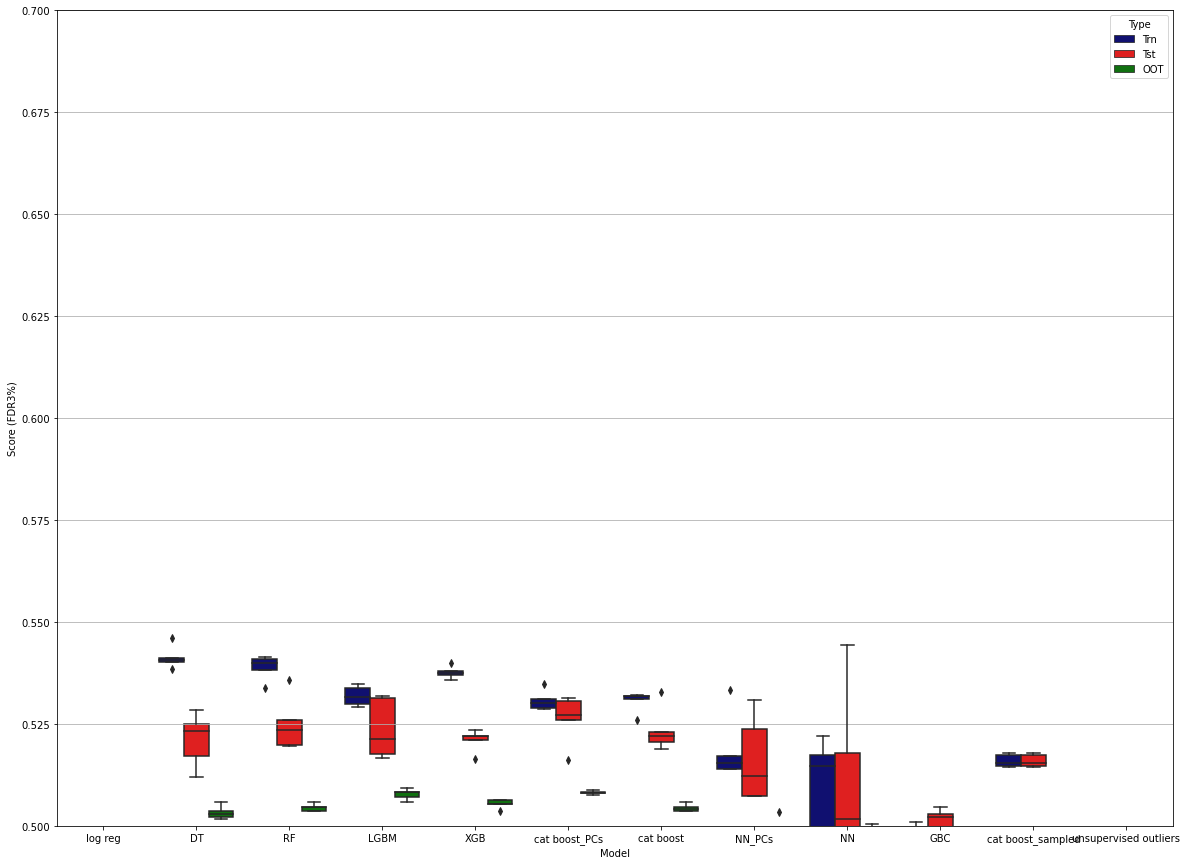

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.7)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [59]:
print('duration: ', datetime.now() - start_time)

duration:  1:02:32.842370


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [60]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model =  lgb.LGBMClassifier(max_depth=10,n_estimators=1000,learning_rate= 0.01)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5250772521987164 0.5396604508767047 0.5088013411567477
1 0.5335478488857108 0.5232300884955752 0.5075440067057837
2 0.534303782364873 0.5184776613348042 0.5075440067057837
3 0.5350575394471467 0.5164896590273896 0.5062866722548198
4 0.5320741268709908 0.5263304541655057 0.5079631181894384
5 0.5313574392412567 0.52491601343785 0.5062866722548198
6 0.5330553901131626 0.5224252491694352 0.5075440067057837
7 0.5344705046197583 0.5192145862552595 0.5092204526404024
8 0.5344643492703761 0.5178870877585243 0.508382229673093
9 0.5270076481835564 0.5358615004122012 0.5075440067057837
10 0.5271485077310321 0.5335698689956332 0.5092204526404024
11 0.5294674556213018 0.5310655046387405 0.508382229673093
12 0.5287697235733776 0.5332588038010061 0.5088013411567477
13 0.5352722028602331 0.5160065111231688 0.508382229673093
14 0.5327437858508605 0.523220665017862 0.5079631181894384
15 0.528777830412127 0.5298905416783609 0.5062866722548198
16 0.532453637660485 0.5243393602225312 0.509639564124057


In [61]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [62]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,...,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60,predicted,Fraud
957048,-3.270118,32.097507,17.021802,14.771219,17.066706,18.042035,-3.043947,17.708394,18.705415,-8.379301,...,17.066277,17.062742,17.065555,16.953849,16.958535,17.004234,17.066162,17.069169,0.999937,0.0
835976,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,0.999936,1.0
884645,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,0.999936,1.0
937013,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,0.999936,1.0
915077,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,0.999936,1.0
865765,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,0.999936,1.0
865961,-3.280209,-0.093321,14.169054,18.477156,15.507693,16.395538,-3.053486,16.090484,16.998315,0.200213,...,14.206705,14.203729,14.206101,14.111849,14.115623,14.154360,14.206612,14.209151,0.999936,1.0
884885,-3.280209,-0.093321,12.742680,16.624188,13.948680,14.749040,-3.053486,14.472575,15.291215,0.200213,...,12.776919,12.774223,12.776374,12.690849,12.694166,12.729423,12.776838,12.779142,0.999936,1.0
865902,-3.280209,-0.093321,12.742680,16.624188,13.948680,14.749040,-3.053486,14.472575,15.291215,0.200213,...,12.776919,12.774223,12.776374,12.690849,12.694166,12.729423,12.776838,12.779142,0.999936,1.0
884916,-3.280209,-0.093321,14.169054,18.477156,15.507693,16.395538,-3.053486,16.090484,16.998315,0.200213,...,14.206705,14.203729,14.206101,14.111849,14.115623,14.154360,14.206612,14.209151,0.999936,1.0


In [63]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,506.0,1159.0,30.390390,69.609610,1665.0,506.0,1159.0,0.308335,48.575021,48.266686,0.436583
2,2.0,1665.0,1631.0,34.0,97.957958,2.042042,3330.0,2137.0,1193.0,1.302199,50.000000,48.697801,1.791282
3,3.0,1665.0,1649.0,16.0,99.039039,0.960961,4995.0,3786.0,1209.0,2.307031,50.670578,48.363547,3.131514
4,4.0,1665.0,1651.0,14.0,99.159159,0.840841,6660.0,5437.0,1223.0,3.313082,51.257334,47.944252,4.445626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1654.0,11.0,99.339339,0.660661,159833.0,157495.0,2338.0,95.970921,97.988265,2.017343,67.363131
97,97.0,1665.0,1648.0,17.0,98.978979,1.021021,161498.0,159143.0,2355.0,96.975144,98.700754,1.725610,67.576645
98,98.0,1665.0,1648.0,17.0,98.978979,1.021021,163163.0,160791.0,2372.0,97.979367,99.413244,1.433877,67.787099
99,99.0,1665.0,1659.0,6.0,99.639640,0.360360,164828.0,162450.0,2378.0,98.990293,99.664711,0.674418,68.313709


In [67]:
FDR_trn

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,5835.0,1567.0,4268.0,26.855184,73.144816,5835.0,1567.0,4268.0,0.272490,50.894348,50.621858,0.367151
2,2.0,5834.0,5691.0,143.0,97.548852,2.451148,11669.0,7258.0,4411.0,1.262112,52.599571,51.337459,1.645432
3,3.0,5835.0,5773.0,62.0,98.937446,1.062554,17504.0,13031.0,4473.0,2.265993,53.338898,51.072905,2.913257
4,4.0,5834.0,5787.0,47.0,99.194378,0.805622,23338.0,18818.0,4520.0,3.272309,53.899356,50.627047,4.163274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,5835.0,5811.0,24.0,99.588689,0.411311,560116.0,551801.0,8315.0,95.954044,99.153351,3.199307,66.362117
97,97.0,5834.0,5811.0,23.0,99.605759,0.394241,565950.0,557612.0,8338.0,96.964533,99.427617,2.463085,66.875989
98,98.0,5835.0,5814.0,21.0,99.640103,0.359897,571785.0,563426.0,8359.0,97.975544,99.678035,1.702491,67.403517
99,99.0,5834.0,5817.0,17.0,99.708605,0.291395,577619.0,569243.0,8376.0,98.987076,99.880754,0.893677,67.961199


In [68]:
FDR_tst

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,2501.0,663.0,1838.0,26.509396,73.490604,2501.0,663.0,1838.0,0.269040,50.759459,50.490419,0.360718
2,2.0,2500.0,2456.0,44.0,98.240000,1.760000,5001.0,3119.0,1882.0,1.265664,51.974593,50.708929,1.657279
3,3.0,2501.0,2483.0,18.0,99.280288,0.719712,7502.0,5602.0,1900.0,2.273244,52.471693,50.198449,2.948421
4,4.0,2500.0,2488.0,12.0,99.520000,0.480000,10002.0,8090.0,1912.0,3.282853,52.803093,49.520240,4.231172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,2501.0,2487.0,14.0,99.440224,0.559776,240051.0,236477.0,3574.0,95.960346,98.702016,2.741670,66.165921
97,97.0,2500.0,2489.0,11.0,99.560000,0.440000,242551.0,238966.0,3585.0,96.970361,99.005800,2.035439,66.657183
98,98.0,2501.0,2485.0,16.0,99.360256,0.639744,245052.0,241451.0,3601.0,97.978753,99.447666,1.468914,67.051097
99,99.0,2500.0,2493.0,7.0,99.720000,0.280000,247552.0,243944.0,3608.0,98.990391,99.640983,0.650592,67.611973


In [64]:
FDR3.to_csv('FDR3.csv')

In [65]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [66]:
print("duration: ", datetime.now() - start_time)

duration:  1:12:11.697171
